# EDA of Features

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

# Define the color palette using Plotly's qualitative colors
plotly_colors = px.colors.qualitative.Plotly
sns.set_palette(plotly_colors)

## Import Data

In [2]:
from importlib import resources as impresources
from recurrent_health_events_prediction import configs
import yaml

with open((impresources.files(configs) / 'data_config.yaml')) as f:
    data_config = yaml.safe_load(f)

In [7]:
training_data_config = data_config["training_data"]["mimic"]
training_data_path = training_data_config["preprocessed_output_path_1st_round"] + "/multiple_hosp_patients"
print(f"Loading training data from {training_data_path}")

Loading training data from /workspaces/msc-thesis-recurrent-health-modeling/data/mimic-iii-preprocessed/copd_hf_renal_diabetes/multiple_hosp_patients


In [9]:
all_events_df = pd.read_csv(training_data_path + '/all_events.csv')
all_events_df['ADMITTIME'] = pd.to_datetime(all_events_df['ADMITTIME'])
all_events_df['DISCHTIME'] = pd.to_datetime(all_events_df['DISCHTIME'])
all_events_df['DOD'] = pd.to_datetime(all_events_df['DOD'])

historical_events_df = all_events_df[all_events_df['IS_LAST_EVENT'] != '1'].copy()

last_events_df = pd.read_csv(training_data_path + '/last_events.csv')

In [10]:
all_events_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE',
       'ETHNICITY', 'DISCHARGE_LOCATION', 'INSURANCE', 'HOSPITALIZATION_DAYS',
       'NUM_COMORBIDITIES', 'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD',
       'HAS_CONGESTIVE_HF', 'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS',
       'PREV_DISCHTIME', 'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION',
       'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
       'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD', 'TOTAL_HOSPITALIZATIONS',
       'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'GENDER', 'DOB', 'DOD',
       'DOD_HOSP', 'AGE', 'CHARLSON_INDEX', 'FIRST_ADMITTIME',
       'LAST_DISCHTIME', 'PARTICIPATION_DAYS', 'TOTAL_PARTICI

In [11]:
last_events_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE',
       'ETHNICITY', 'DISCHARGE_LOCATION', 'INSURANCE', 'HOSPITALIZATION_DAYS',
       'NUM_COMORBIDITIES', 'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD',
       'HAS_CONGESTIVE_HF', 'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS',
       'PREV_DISCHTIME', 'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION',
       'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
       'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD', 'TOTAL_HOSPITALIZATIONS',
       'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'GENDER', 'DOB', 'DOD',
       'DOD_HOSP', 'AGE', 'CHARLSON_INDEX', 'FIRST_ADMITTIME',
       'LAST_DISCHTIME', 'PARTICIPATION_DAYS', 'TOTAL_PARTICI

In [12]:
event_type_color_map = {
    'Readmission after Discharge': px.colors.qualitative.Plotly[0],
    'In-Hospital Death': px.colors.qualitative.Plotly[1],
    'Death After Hospital Discharge': px.colors.qualitative.Plotly[2],
    'No Readmission or No Death after Discharge': px.colors.qualitative.Plotly[4]
}

In [13]:
def classify_event(row):
    if row['READMISSION_EVENT'] == 1:
        return 'Readmission after Discharge'
    elif row['IN_HOSP_DEATH_EVENT'] == 1:
        return 'In-Hospital Death'
    elif row['AFTER_HOSP_DEATH_EVENT'] == 1:
        return 'Death After Hospital Discharge'
    else:
        return 'No Readmission or No Death after Discharge'

all_events_df['EVENT_TYPE'] = all_events_df.apply(classify_event, axis=1)
last_events_df['EVENT_TYPE'] = last_events_df.apply(classify_event, axis=1)
historical_events_df['EVENT_TYPE'] = historical_events_df.apply(classify_event, axis=1)

In [14]:
eda_plots_path = "/workspaces/master-thesis-recurrent-health-events-prediction/assets/plots/eda/mimic/"

## Last Events

In [15]:
print("Num of unique patients in last_events_df:", last_events_df['SUBJECT_ID'].nunique())
print("Num of events in last_events_df:", len(last_events_df))

Num of unique patients in last_events_df: 1878
Num of events in last_events_df: 1878


In [16]:
last_events_df[['DAYS_UNTIL_NEXT_HOSPITALIZATION', 'EVENT_DURATION']].describe()

DAYS_UNTIL_NEXT_HOSPITALIZATION  EVENT_DURATION
count                      1878.000000     1878.000000
mean                        334.391224       78.610586
std                         505.724795       46.827454
min                           1.004167        1.004167
25%                          28.313194       28.313194
50%                         115.147917      115.147917
75%                         443.309549      120.000000
max                        3679.084028      120.000000

#### One-Hot Encoding

In [17]:
last_events_df.INSURANCE.value_counts(normalize=True)*100

INSURANCE
Medicare      71.139510
Private       19.275825
Medicaid       8.466454
Government     1.011715
Self Pay       0.106496
Name: proportion, dtype: float64

In [18]:
from recurrent_health_events_prediction.preprocessing.utils import remap_discharge_location, remap_mimic_races, one_hot_encode_and_drop

last_events_df = remap_discharge_location(last_events_df)
last_events_df = remap_mimic_races(last_events_df)

features_to_encode = ['GENDER', 'INSURANCE', 'ADMISSION_TYPE', 'ETHNICITY', 'DISCHARGE_LOCATION']
one_hot_cols_to_drop = ['GENDER_F', 'INSURANCE_SELF_PAY', 'ADMISSION_TYPE_EMERGENCY', 'ETHNICITY_OTHER', 'DISCHARGE_LOCATION_OTHERS']
last_events_df, new_features = one_hot_encode_and_drop(last_events_df, features_to_encode, one_hot_cols_to_drop)

In [19]:
new_features = sorted(new_features)
print("New features after one-hot encoding:")
for feature in new_features:
    print(feature)

New features after one-hot encoding:
ADMISSION_TYPE_ELECTIVE
ADMISSION_TYPE_URGENT
DISCHARGE_LOCATION_HOME
DISCHARGE_LOCATION_POST_ACUTE_CARE
ETHNICITY_BLACK
ETHNICITY_HISPANIC
ETHNICITY_WHITE
GENDER_M
INSURANCE_GOVERNMENT
INSURANCE_MEDICAID
INSURANCE_MEDICARE
INSURANCE_PRIVATE
NEXT_ADMISSION_TYPE


#### Overview

In [20]:
new_features

['ADMISSION_TYPE_ELECTIVE',
 'ADMISSION_TYPE_URGENT',
 'DISCHARGE_LOCATION_HOME',
 'DISCHARGE_LOCATION_POST_ACUTE_CARE',
 'ETHNICITY_BLACK',
 'ETHNICITY_HISPANIC',
 'ETHNICITY_WHITE',
 'GENDER_M',
 'INSURANCE_GOVERNMENT',
 'INSURANCE_MEDICAID',
 'INSURANCE_MEDICARE',
 'INSURANCE_PRIVATE',
 'NEXT_ADMISSION_TYPE']

In [21]:
last_events_df['READMISSION_EVENT_LABEL'] = last_events_df['READMISSION_EVENT'].map(
    {0: f'No Readmission 120 days', 1: f'Readmission 120 days'}
)

<Figure size 1000x3000 with 0 Axes>

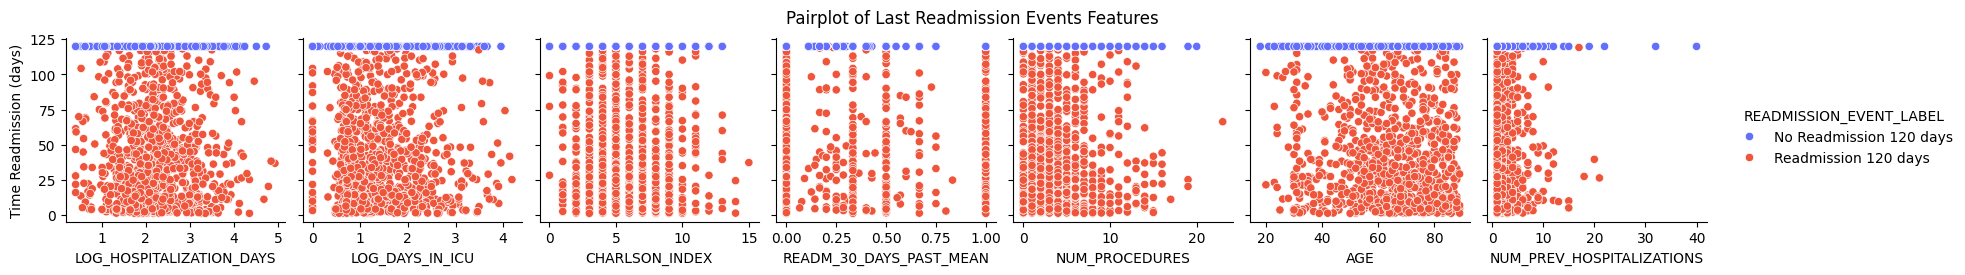

In [22]:
plt.figure(figsize=(10, 30))
variables = ['LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'CHARLSON_INDEX', 'READM_30_DAYS_PAST_MEAN', 'NUM_PROCEDURES', 'AGE', 'NUM_PREV_HOSPITALIZATIONS']
pair_grid = sns.pairplot(last_events_df[variables + ["EVENT_DURATION", 'READMISSION_EVENT_LABEL']], hue='READMISSION_EVENT_LABEL', diag_kind='kde', markers='o', height=2.5, x_vars=variables, y_vars=["EVENT_DURATION"])
for axis in pair_grid.axes.flatten():
    axis.set_ylabel('Time Readmission (days)')

plt.suptitle(f'Pairplot of Last Readmission Events Features', y=1.06)
plt.show()

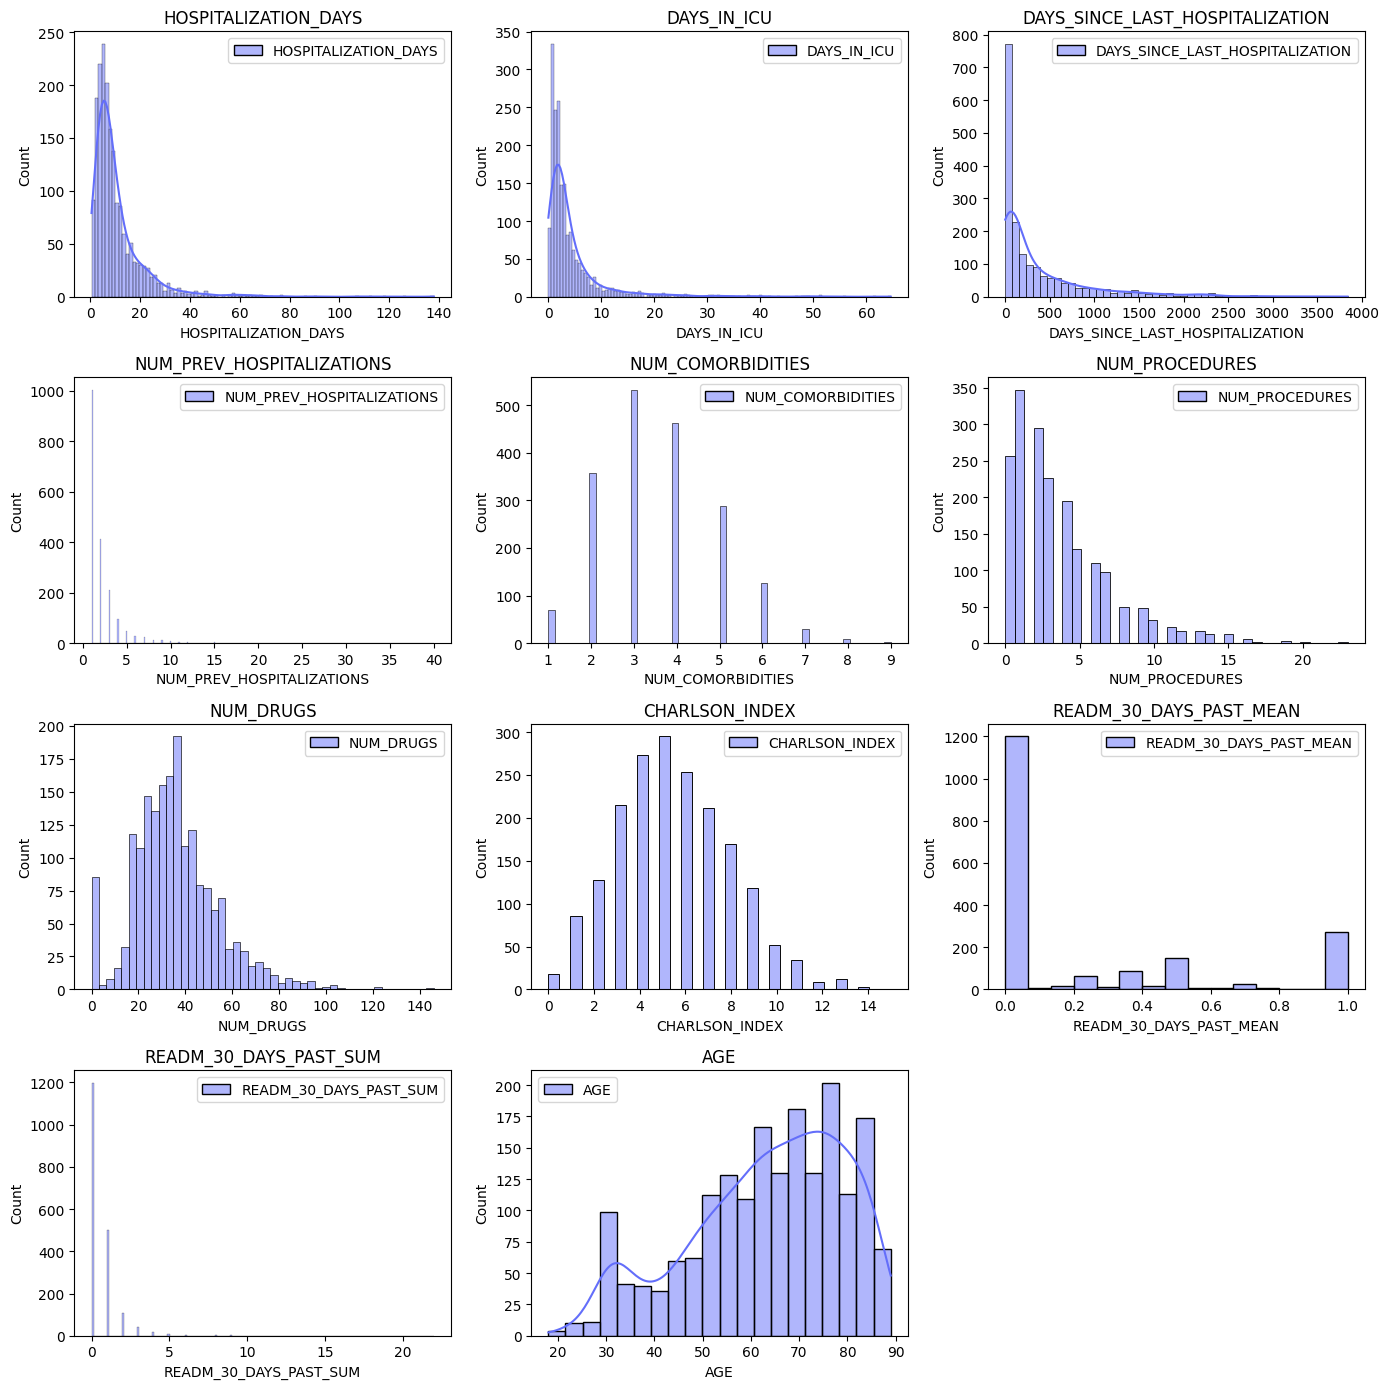

HOSPITALIZATION_DAYS  DAYS_IN_ICU  DAYS_SINCE_LAST_HOSPITALIZATION  \
count           1878.000000  1878.000000                      1878.000000   
mean              10.921323     4.395760                       384.384430   
std               11.864509     6.412042                       569.759122   
min                0.500000     0.000000                         1.036806   
25%                4.309722     1.220992                        29.743924   
50%                7.360417     2.304282                       130.815972   
75%               12.832812     4.717839                       513.066667   
max              137.965278    64.583819                      3837.107639   

       NUM_PREV_HOSPITALIZATIONS  NUM_COMORBIDITIES  NUM_PROCEDURES  \
count                1878.000000        1878.000000     1878.000000   
mean                    2.168797           3.584665        3.596912   
std                     2.348385           1.369046        3.378129   
min                     1.000000           1.000000        0.000000   
25%                     1.000000           3.000000        1.000000   
50%                     1.000000           3.000000        3.000000   
75%                     2.000000           4.000000        5.000000   
max                    40.000000           9.000000       23.000000   

         NUM_DRUGS  CHARLSON_INDEX  READM_30_DAYS_PAST_MEAN  \
count  1878.000000     1878.000000              1878.000000   
mean     36.006922        5.423855                 0.232733   
std      18.012647        2.566599                 0.362403   
min       0.000000        0.000000                 0.000000   
25%      25.000000        4.000000                 0.000000   
50%      34.000000        5.000000                 0.000000   
75%      45.000000        7.000000                 0.428571   
max     146.000000       15.000000                 1.000000   

       READM_30_DAYS_PAST_SUM          AGE  
count             1878.000000  1878.000000  
mean                 0.534611    63.400426  
std                  1.038228    16.019016  
min                  0.000000    18.000000  
25%                  0.000000    53.000000  
50%                  0.000000    66.000000  
75%                  1.000000    76.000000  
max                 22.000000    89.000000

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_plot = [
    "HOSPITALIZATION_DAYS",
    "DAYS_IN_ICU",
    "DAYS_SINCE_LAST_HOSPITALIZATION",
    "NUM_PREV_HOSPITALIZATIONS",
    "NUM_COMORBIDITIES",
    "NUM_PROCEDURES",
    "NUM_DRUGS",
    "CHARLSON_INDEX",
    "READM_30_DAYS_PAST_MEAN",
    "READM_30_DAYS_PAST_SUM",
    "AGE",
]
col_kde = [
    "HOSPITALIZATION_DAYS",
    "DAYS_IN_ICU",
    "AGE",
    "DAYS_SINCE_LAST_HOSPITALIZATION",
]

n_cols = 3
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 14))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(last_events_df[[col]].dropna(), kde=(col in col_kde), ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Hide any unused subplots
for j in range(len(columns_to_plot), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

last_events_df[columns_to_plot].describe()

In [24]:
from recurrent_health_events_prediction.eda.utils import get_main_metrics_specific_cols
cols = ['HOSPITALIZATION_DAYS', 'DAYS_IN_ICU', 'DAYS_SINCE_LAST_HOSPITALIZATION']
get_main_metrics_specific_cols(last_events_df, cols, metrics=['mean', 'median', 'std', 'kurtosis', 'skew'])

Metric  HOSPITALIZATION_DAYS  DAYS_IN_ICU  \
0      mean                10.921        4.396   
1    median                 7.360        2.304   
2       std                11.865        6.412   
3  kurtosis                25.865       22.841   
4      skew                 4.023        4.149   

   DAYS_SINCE_LAST_HOSPITALIZATION  
0                          384.384  
1                          130.816  
2                          569.759  
3                            6.846  
4                            2.424

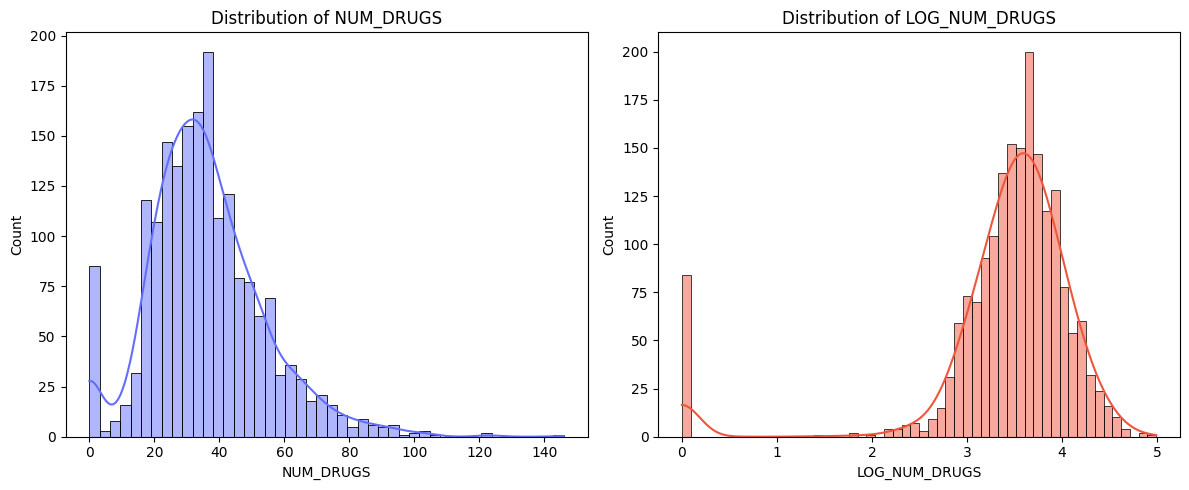

In [25]:
# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

# Plot the distribution of NUM_DRUGS
sns.histplot(last_events_df['NUM_DRUGS'], kde=True, ax=axes[0], color=plotly_colors[0])
axes[0].set_title('Distribution of NUM_DRUGS')
axes[0].set_xlabel('NUM_DRUGS')
axes[0].set_ylabel('Count')

# Plot the distribution of LOG_NUM_DRUGS
sns.histplot(last_events_df['LOG_NUM_DRUGS'], kde=True, ax=axes[1], color=plotly_colors[1])
axes[1].set_title('Distribution of LOG_NUM_DRUGS')
axes[1].set_xlabel('LOG_NUM_DRUGS')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

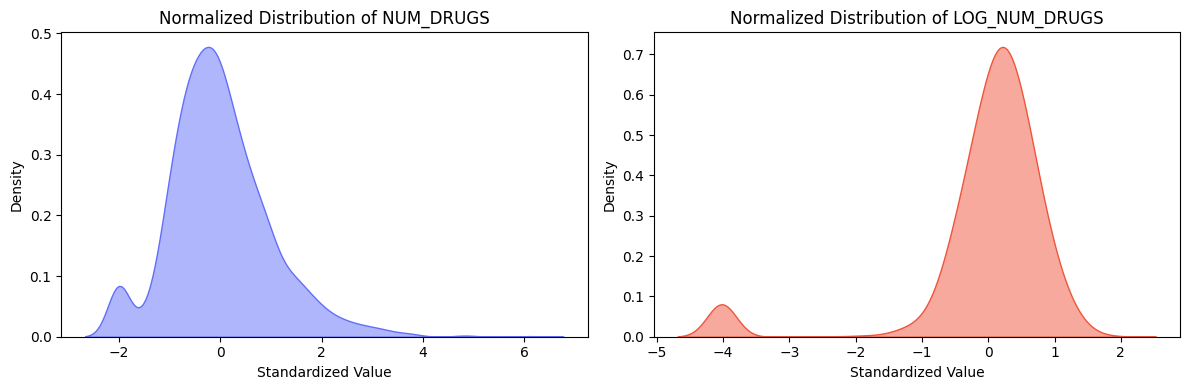

In [26]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the columns
scaled_num_drugs_df = last_events_df[['LOG_NUM_DRUGS', 'NUM_DRUGS']].copy()

# Scale the features
scaler = StandardScaler()
scaled_num_drugs_df[['LOG_NUM_DRUGS', 'NUM_DRUGS']] = scaler.fit_transform(scaled_num_drugs_df)

# Plot the distributions side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(['NUM_DRUGS', 'LOG_NUM_DRUGS']):
    sns.kdeplot(scaled_num_drugs_df[col], fill=True, alpha=0.5, ax=axes[i], color=plotly_colors[i])
    axes[i].set_title(f"Normalized Distribution of {col}")
    axes[i].set_xlabel("Standardized Value")
    axes[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

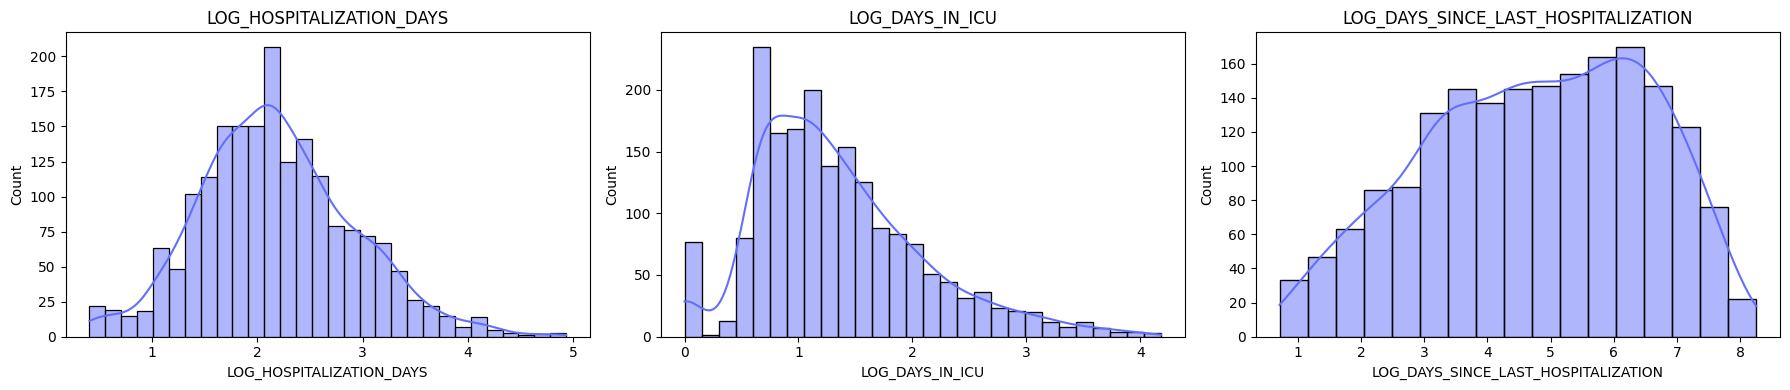

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_plot = ['LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'LOG_DAYS_SINCE_LAST_HOSPITALIZATION']

n_cols = 3
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(last_events_df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(len(columns_to_plot), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [28]:
from recurrent_health_events_prediction.eda.utils import get_main_metrics_specific_cols

get_main_metrics_specific_cols(last_events_df, columns_to_plot, metrics=['mean', 'median', 'kurtosis', 'skew'])

Metric  LOG_HOSPITALIZATION_DAYS  LOG_DAYS_IN_ICU  \
0      mean                     2.182            1.344   
1    median                     2.124            1.195   
2  kurtosis                     0.297            0.915   
3      skew                     0.339            0.875   

   LOG_DAYS_SINCE_LAST_HOSPITALIZATION  
0                                4.773  
1                                4.881  
2                               -0.833  
3                               -0.242

In [48]:
binary_features = [
    "HAS_DIABETES",
    "HAS_COPD",
    "HAS_CONGESTIVE_HF",
    "PREV_READMISSION_30_DAYS",
] + new_features

try:
    binary_features.remove('NEXT_ADMISSION_TYPE')
except ValueError:
    pass

print("Binary features to analyze: ")
for feature in binary_features:
    print(feature)

Binary features to analyze: 
HAS_DIABETES
HAS_COPD
HAS_CONGESTIVE_HF
PREV_READMISSION_30_DAYS
ADMISSION_TYPE_ELECTIVE
ADMISSION_TYPE_URGENT
DISCHARGE_LOCATION_HOME
DISCHARGE_LOCATION_POST_ACUTE_CARE
ETHNICITY_BLACK
ETHNICITY_HISPANIC
ETHNICITY_WHITE
GENDER_M
INSURANCE_GOVERNMENT
INSURANCE_MEDICAID
INSURANCE_MEDICARE
INSURANCE_PRIVATE


In [49]:
# Calculate proportions for each binary feature
proportions = last_events_df[binary_features].mean().reset_index()
proportions.columns = ["Feature", "Proportion"]

# Display the table
print(proportions.to_markdown(index=False))

| Feature                            |   Proportion |
|:-----------------------------------|-------------:|
| HAS_DIABETES                       |    0.421193  |
| HAS_COPD                           |    0.390309  |
| HAS_CONGESTIVE_HF                  |    0.526092  |
| PREV_READMISSION_30_DAYS           |    0.250799  |
| ADMISSION_TYPE_ELECTIVE            |    0.100639  |
| ADMISSION_TYPE_URGENT              |    0.0127796 |
| DISCHARGE_LOCATION_HOME            |    0.49148   |
| DISCHARGE_LOCATION_POST_ACUTE_CARE |    0.486688  |
| ETHNICITY_BLACK                    |    0.159744  |
| ETHNICITY_HISPANIC                 |    0.0394036 |
| ETHNICITY_WHITE                    |    0.728967  |
| GENDER_M                           |    0.541001  |
| INSURANCE_GOVERNMENT               |    0.0101171 |
| INSURANCE_MEDICAID                 |    0.0846645 |
| INSURANCE_MEDICARE                 |    0.711395  |
| INSURANCE_PRIVATE                  |    0.192758  |


#### Correlation Analysis - Between Numerical Features

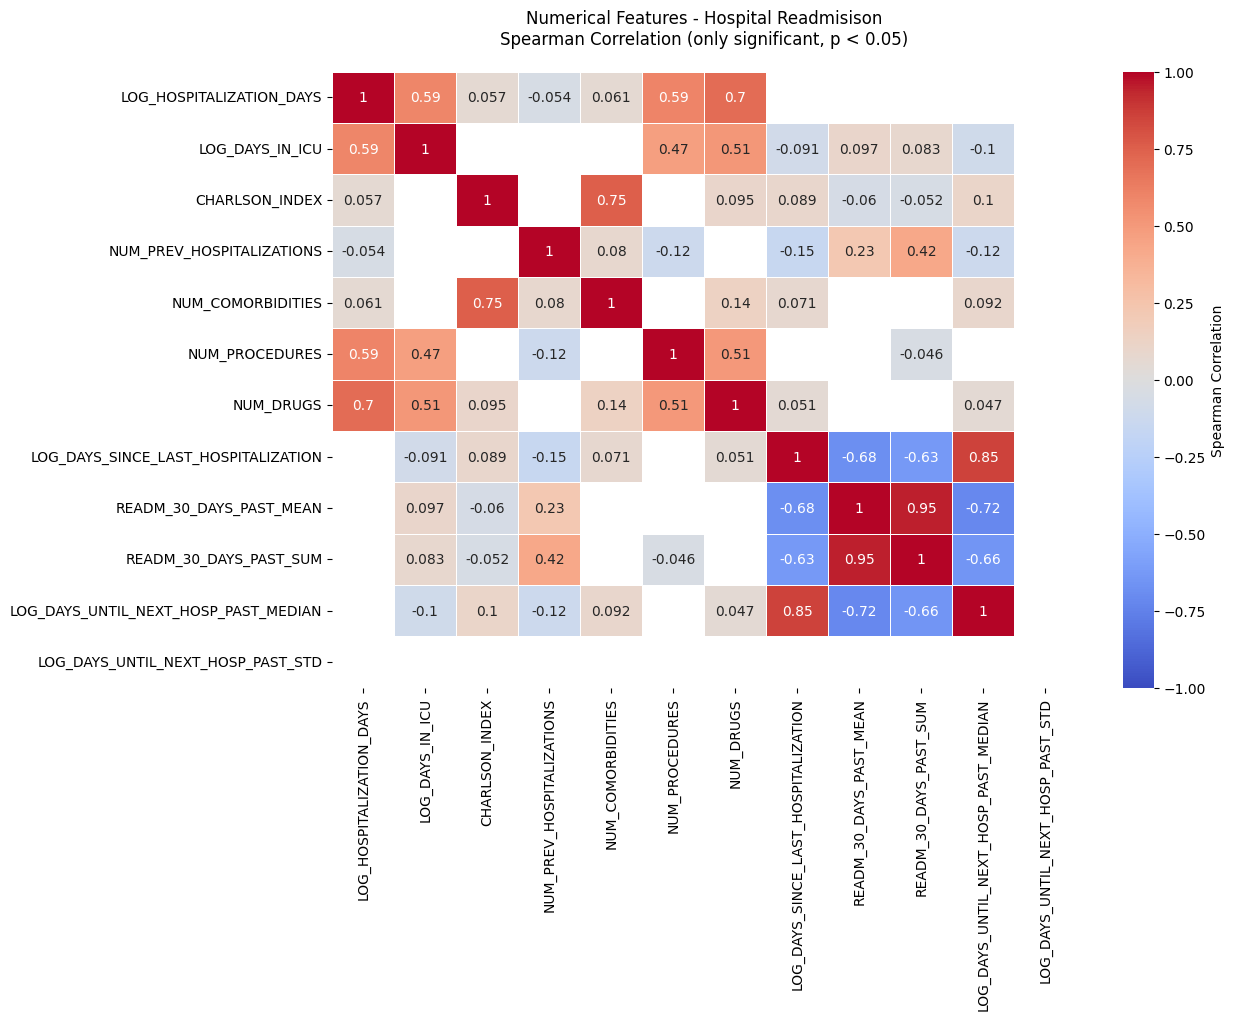

In [31]:
from scipy.stats import spearmanr

features = [
    'LOG_HOSPITALIZATION_DAYS',
    'LOG_DAYS_IN_ICU',
    'CHARLSON_INDEX',
    'NUM_PREV_HOSPITALIZATIONS',
    'NUM_COMORBIDITIES',
    'NUM_PROCEDURES',
    'NUM_DRUGS',
    'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
    'READM_30_DAYS_PAST_MEAN',
    'READM_30_DAYS_PAST_SUM',
    'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
    'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD',
]

corr, pval = spearmanr(last_events_df[features])
corr_df = pd.DataFrame(corr, index=features, columns=features)
pval_df = pd.DataFrame(pval, index=features, columns=features)

# Mask for non-significant correlations
alpha = 0.05
mask_non_significant = pval_df > alpha

# Set non-significant correlations to NaN (optional, for gray-out)
corr_sig = corr_df.mask(mask_non_significant)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_sig, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5,
            mask=mask_non_significant, cbar_kws={"label": "Spearman Correlation"})
plt.title("Numerical Features - Hospital Readmisison\nSpearman Correlation (only significant, p < 0.05)", pad=20)
plt.show()

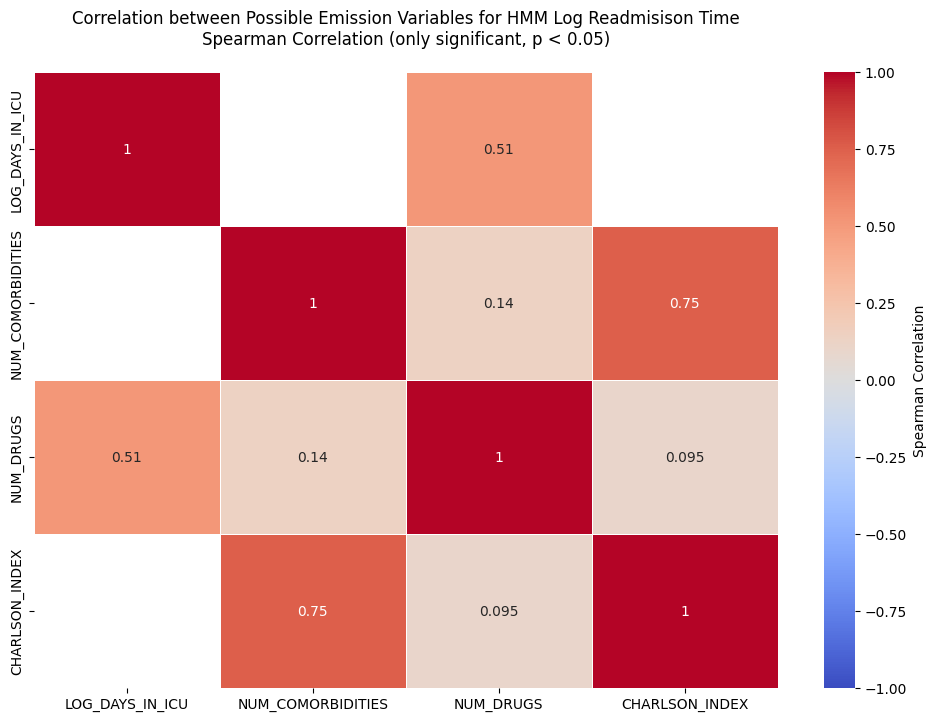

In [32]:
from scipy.stats import spearmanr

subset_features = [
   'LOG_DAYS_IN_ICU',
   'NUM_COMORBIDITIES',
   'NUM_DRUGS',
   'CHARLSON_INDEX',
   
]

corr, pval = spearmanr(last_events_df[subset_features])
corr_subset_df = pd.DataFrame(corr, index=subset_features, columns=subset_features)
pval_df = pd.DataFrame(pval, index=subset_features, columns=subset_features)

# Mask for non-significant correlations
alpha = 0.05
mask_non_significant = pval_df > alpha

# Set non-significant correlations to NaN (optional, for gray-out)
corr_sig = corr_subset_df.mask(mask_non_significant)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_sig, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=.5,
            mask=mask_non_significant, cbar_kws={"label": "Spearman Correlation"})
plt.title("Correlation between Possible Emission Variables for HMM Log Readmisison Time\nSpearman Correlation (only significant, p < 0.05)", pad=20)
plt.show()

### Correlation with Log Readmission Time

In [33]:
numerical_features = [
    'LOG_HOSPITALIZATION_DAYS',
    'LOG_DAYS_IN_ICU',
    'CHARLSON_INDEX',
    'NUM_PREV_HOSPITALIZATIONS',
    'NUM_COMORBIDITIES',
    'NUM_PROCEDURES',
    'NUM_DRUGS',
    'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
    'READM_30_DAYS_PAST_MEAN',
    'READM_30_DAYS_PAST_SUM',
    'AGE',
    'READM_30_DAYS_PAST_MEAN',
    'READM_30_DAYS_PAST_SUM',
    'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
    'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD',
]

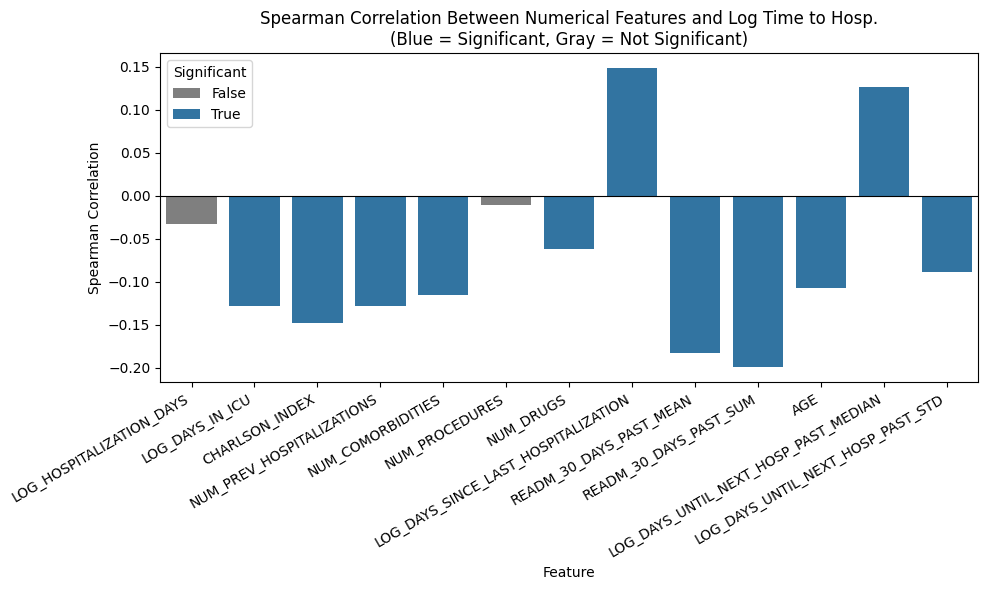

feature  spearman_corr       p_value  \
0               LOG_HOSPITALIZATION_DAYS      -0.032476  1.594841e-01   
1                        LOG_DAYS_IN_ICU      -0.128457  2.320416e-08   
2                         CHARLSON_INDEX      -0.147367  1.388890e-10   
3              NUM_PREV_HOSPITALIZATIONS      -0.127699  2.808041e-08   
4                      NUM_COMORBIDITIES      -0.115141  5.642713e-07   
5                         NUM_PROCEDURES      -0.010357  6.537570e-01   
6                              NUM_DRUGS      -0.061607  7.572886e-03   
7    LOG_DAYS_SINCE_LAST_HOSPITALIZATION       0.148210  1.087723e-10   
8                READM_30_DAYS_PAST_MEAN      -0.182360  1.660860e-15   
9                 READM_30_DAYS_PAST_SUM      -0.199296  2.819078e-18   
10                                   AGE      -0.107275  3.174137e-06   
11               READM_30_DAYS_PAST_MEAN      -0.182360  1.660860e-15   
12                READM_30_DAYS_PAST_SUM      -0.199296  2.819078e-18   
13  LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN       0.125894  4.402725e-08   
14     LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD      -0.088098  9.125099e-03   

    significant  
0         False  
1          True  
2          True  
3          True  
4          True  
5         False  
6          True  
7          True  
8          True  
9          True  
10         True  
11         True  
12         True  
13         True  
14         True

In [34]:
from scipy.stats import spearmanr
period = 180  # days
df = last_events_df[last_events_df['DAYS_UNTIL_NEXT_HOSPITALIZATION'].notna()]  # Filter for event durations less than 365 days

#target = 'EVENT_DURATION'
target = 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION'

correlations = []
p_values = []

for feat in numerical_features:
    coef, pval = spearmanr(df[feat], df[target], nan_policy='omit')
    correlations.append(coef)
    p_values.append(pval)

result_df = pd.DataFrame({
    'feature': numerical_features,
    'spearman_corr': correlations,
    'p_value': p_values
})

# Mark significance
alpha = 0.05
result_df['significant'] = result_df['p_value'] < alpha

plt.figure(figsize=(10, 6))
sns.barplot(
    data=result_df,
    x='feature',
    y='spearman_corr',
    hue='significant',
    palette={True: 'tab:blue', False: 'tab:gray'}
)
plt.axhline(0, color='black', linewidth=0.8)
plt.title(f"Spearman Correlation Between Numerical Features and Log Time to Hosp.\n(Blue = Significant, Gray = Not Significant)")
plt.ylabel("Spearman Correlation")
plt.xlabel("Feature")
plt.legend(title='Significant')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
result_df

In [35]:
last_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1878 entries, 0 to 1877
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SUBJECT_ID                            1878 non-null   int64  
 1   HADM_ID                               1878 non-null   int64  
 2   ADMITTIME                             1878 non-null   object 
 3   DISCHTIME                             1878 non-null   object 
 4   HOSPITALIZATION_DAYS                  1878 non-null   float64
 5   NUM_COMORBIDITIES                     1878 non-null   int64  
 6   TYPES_COMORBIDITIES                   1878 non-null   object 
 7   HAS_DIABETES                          1878 non-null   bool   
 8   HAS_COPD                              1878 non-null   bool   
 9   HAS_CONGESTIVE_HF                     1878 non-null   bool   
 10  NEXT_ADMISSION_TYPE                   1878 non-null   object 
 11  NUM_PREV_HOSPITAL

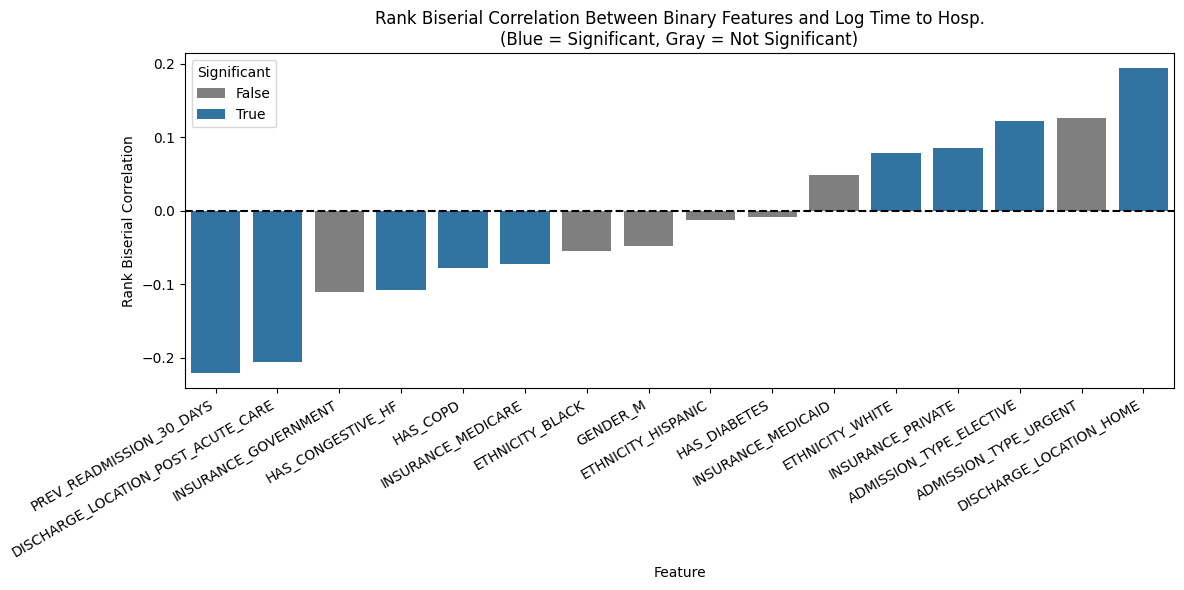

feature  rank_biserial_corr       p_value  \
0                         HAS_DIABETES           -0.008698  7.472708e-01   
1                             HAS_COPD           -0.078193  4.206077e-03   
2                    HAS_CONGESTIVE_HF           -0.108401  4.873454e-05   
3             PREV_READMISSION_30_DAYS           -0.221066  6.443476e-13   
4              ADMISSION_TYPE_ELECTIVE            0.121981  5.891602e-03   
5                ADMISSION_TYPE_URGENT            0.126259  2.873292e-01   
6              DISCHARGE_LOCATION_HOME            0.193844  3.543580e-13   
7   DISCHARGE_LOCATION_POST_ACUTE_CARE           -0.206459  9.668277e-15   
8                      ETHNICITY_BLACK           -0.055196  1.291606e-01   
9                   ETHNICITY_HISPANIC           -0.012360  8.568884e-01   
10                     ETHNICITY_WHITE            0.079104  8.329051e-03   
11                            GENDER_M           -0.047480  7.582788e-02   
12                INSURANCE_GOVERNMENT           -0.110501  4.067658e-01   
13                  INSURANCE_MEDICAID            0.048577  3.102596e-01   
14                  INSURANCE_MEDICARE           -0.072521  1.367183e-02   
15                   INSURANCE_PRIVATE            0.085065  1.180484e-02   

    significant  
0         False  
1          True  
2          True  
3          True  
4          True  
5         False  
6          True  
7          True  
8         False  
9         False  
10         True  
11        False  
12        False  
13        False  
14         True  
15         True

In [36]:
from scipy.stats import mannwhitneyu
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def rank_biserial(u_stat, n1, n2):
    # positive when group1 > group0
    return (2*u_stat) / (n1*n2) - 1

results = []

for feat in binary_features:
    group0 = df[df[feat] == 0][target]
    group1 = df[df[feat] == 1][target]

    if group0.empty or group1.empty:
        continue

    u_stat, pval = mannwhitneyu(group1, group0, alternative='two-sided')  # order matters for sign
    n1, n2 = len(group1), len(group0)
    rbc = rank_biserial(u_stat, n1, n2)

    results.append({
        'feature': feat,
        'rank_biserial_corr': rbc,
        'p_value': pval
    })

results_df = pd.DataFrame(results)
results_df['significant'] = results_df['p_value'] < 0.05

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=results_df.sort_values('rank_biserial_corr'),
    x='feature',
    y='rank_biserial_corr',
    hue='significant',
    palette={True: 'tab:blue', False: 'tab:gray'}
)
plt.axhline(0, color='black', linestyle='--')
plt.title("Rank Biserial Correlation Between Binary Features and Log Time to Hosp.\n(Blue = Significant, Gray = Not Significant)")
plt.ylabel("Rank Biserial Correlation")
plt.xlabel("Feature")
plt.legend(title='Significant')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
results_df


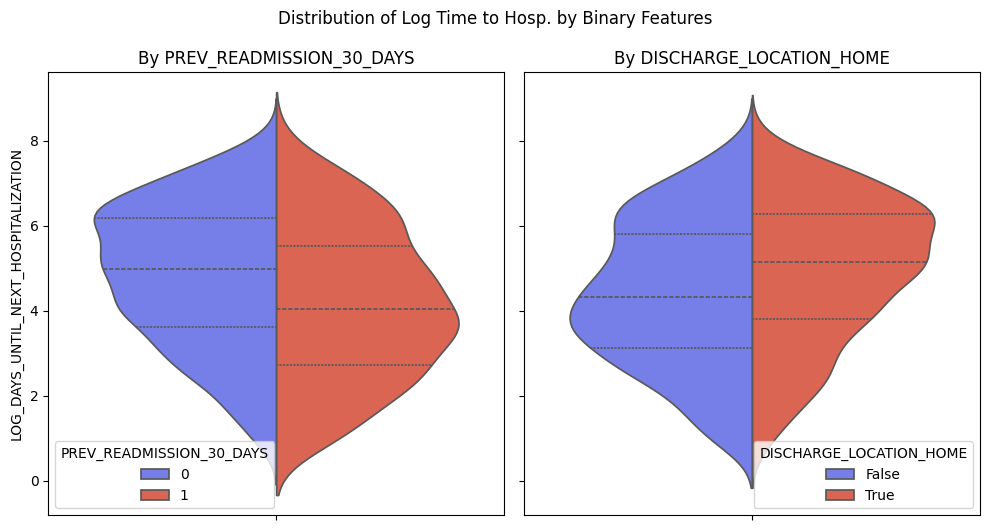

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

cols = ['PREV_READMISSION_30_DAYS', 'DISCHARGE_LOCATION_HOME']

for col, ax in zip(cols, axes):
    sns.violinplot(
        data=last_events_df,
        y=target,
        hue=col,
        split=True,
        inner='quartile',
        ax=ax
    )
    ax.set_title(f"By {col}")
    ax.set_ylabel('LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION')

plt.tight_layout()
plt.suptitle("Distribution of Log Time to Hosp. by Binary Features", y=1.05)
plt.show()

### Correlation with Binary Target "Readmission within 30 days"

##### Binary Features

Binary features: ['HAS_DIABETES', 'HAS_COPD', 'HAS_CONGESTIVE_HF', 'PREV_READMISSION_30_DAYS', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_URGENT', 'DISCHARGE_LOCATION_HOME', 'DISCHARGE_LOCATION_POST_ACUTE_CARE', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC', 'ETHNICITY_WHITE', 'GENDER_M', 'INSURANCE_GOVERNMENT', 'INSURANCE_MEDICAID', 'INSURANCE_MEDICARE', 'INSURANCE_PRIVATE']


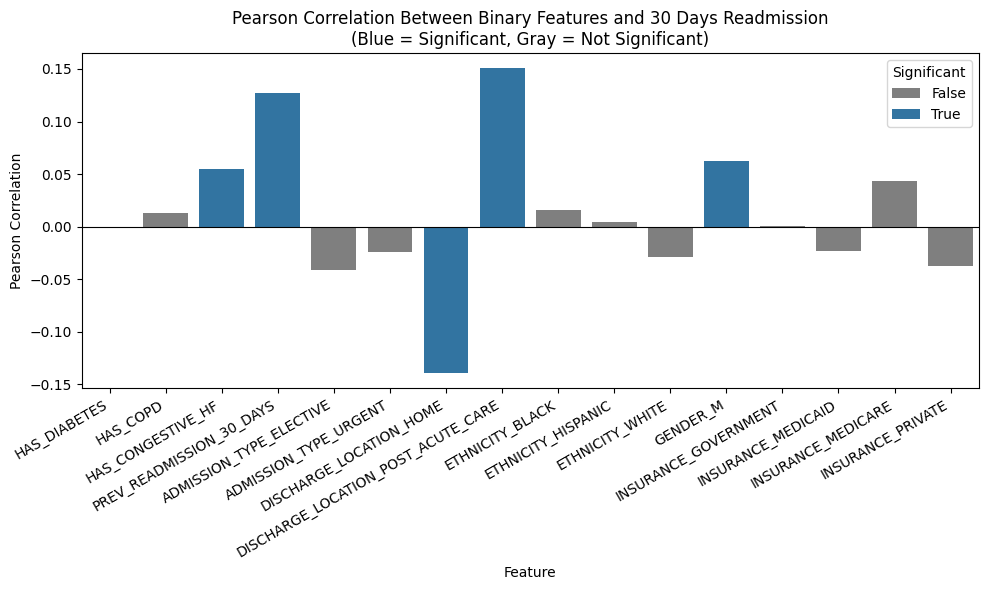

feature  pearson_corr       p_value  \
0                         HAS_DIABETES      0.000090  9.968801e-01   
1                             HAS_COPD      0.012782  5.798594e-01   
2                    HAS_CONGESTIVE_HF      0.055262  1.661655e-02   
3             PREV_READMISSION_30_DAYS      0.126970  3.369985e-08   
4              ADMISSION_TYPE_ELECTIVE     -0.041188  7.434179e-02   
5                ADMISSION_TYPE_URGENT     -0.024297  2.926164e-01   
6              DISCHARGE_LOCATION_HOME     -0.139155  1.396558e-09   
7   DISCHARGE_LOCATION_POST_ACUTE_CARE      0.150535  5.504218e-11   
8                      ETHNICITY_BLACK      0.016179  4.834964e-01   
9                   ETHNICITY_HISPANIC      0.004563  8.433506e-01   
10                     ETHNICITY_WHITE     -0.028567  2.159389e-01   
11                            GENDER_M      0.061971  7.223857e-03   
12                INSURANCE_GOVERNMENT      0.000639  9.779171e-01   
13                  INSURANCE_MEDICAID     -0.023541  3.079034e-01   
14                  INSURANCE_MEDICARE      0.043188  6.131546e-02   
15                   INSURANCE_PRIVATE     -0.037708  1.023422e-01   

    significant  
0         False  
1         False  
2          True  
3          True  
4         False  
5         False  
6          True  
7          True  
8         False  
9         False  
10        False  
11         True  
12        False  
13        False  
14        False  
15        False

In [50]:
from scipy.stats import pearsonr


target = 'READMISSION_30_DAYS'
print(f"Binary features: {binary_features}")

correlations = []
p_values = []

for binary_feature in binary_features:
    if binary_feature not in last_events_df.columns:
        print(f"Feature {binary_feature} not found in DataFrame.")
        continue
    
    # Calculate Pearson correlation
    corr, pval = pearsonr(last_events_df[binary_feature], last_events_df[target])
    correlations.append(corr)
    p_values.append(pval)
    
result_df = pd.DataFrame({
    'feature': binary_features,
    'pearson_corr': correlations,
    'p_value': p_values
})

# Mark significance
alpha = 0.05
result_df['significant'] = result_df['p_value'] < alpha
plt.figure(figsize=(10, 6))
sns.barplot(
    data=result_df,
    x='feature',
    y='pearson_corr',
    hue='significant',
    palette={True: 'tab:blue', False: 'tab:gray'}
)
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Pearson Correlation Between Binary Features and 30 Days Readmission\n(Blue = Significant, Gray = Not Significant)")
plt.ylabel("Pearson Correlation")
plt.xlabel("Feature")
plt.legend(title='Significant')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
result_df

##### Continuous Features Analysis - Mann Whitney U Test

The **Mann-Whitney U test** is a non-parametric statistical test used to determine whether two independent groups come from the same distribution. Unlike a t-test, it does **not assume normality** of the data, making it well-suited for skewed or ordinal feature distributions.

 **Why Use It Here?**

In this analysis, we are evaluating whether each feature has a significantly different distribution between:
- Patients **readmitted within 30 days** (`READMISSION_30_DAYS = 1`)  
- Patients **not readmitted** (`READMISSION_30_DAYS = 0`)

For each feature:
- We split the data based on readmission status.
- We apply the Mann-Whitney U test to compare the two groups.
- We compute the **p-value** to assess significance.
- We compute the **median difference** between the two groups to capture the direction and magnitude of the effect.

**Interpretation:**
- A **low p-value** (typically < 0.05) indicates that the feature distribution differs significantly between the two groups.
- The **median difference** shows which group tends to have higher values:
  - Positive value → higher median in readmitted group.
  - Negative value → higher median in non-readmitted group.

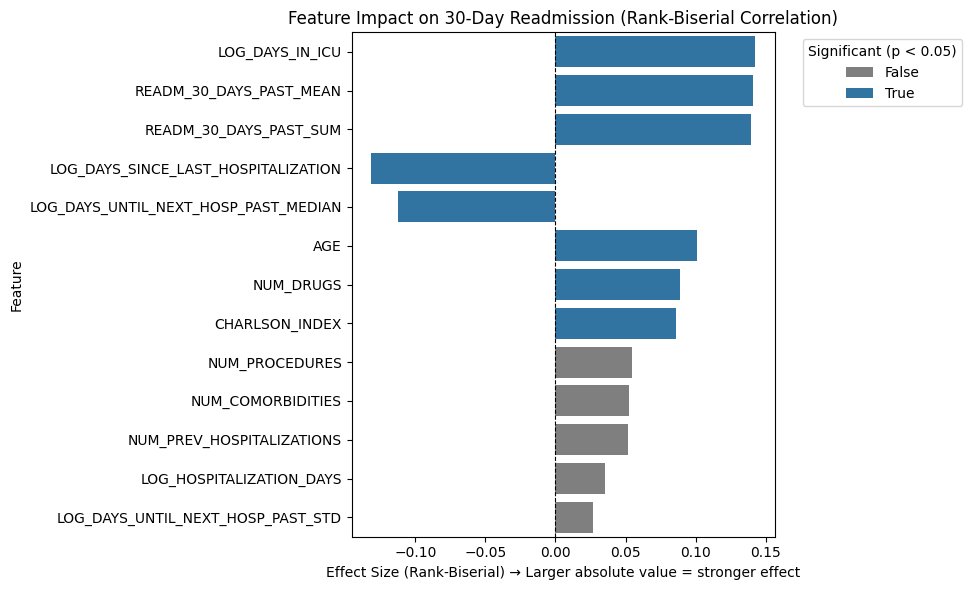

feature    u_stat       p_value  median_diff  \
1                        LOG_DAYS_IN_ICU  291175.5  2.644483e-06     0.159889   
11               READM_30_DAYS_PAST_MEAN  291760.5  6.377560e-08     0.000000   
8                READM_30_DAYS_PAST_MEAN  291760.5  6.377560e-08     0.000000   
9                 READM_30_DAYS_PAST_SUM  292158.0  5.971455e-08     0.000000   
12                READM_30_DAYS_PAST_SUM  292158.0  5.971455e-08     0.000000   
7    LOG_DAYS_SINCE_LAST_HOSPITALIZATION  384315.0  1.458993e-05    -0.590848   
13  LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN  377891.5  2.056883e-04    -0.420795   
10                                   AGE  305378.5  9.001192e-04     4.000000   
6                              NUM_DRUGS  309389.5  3.377122e-03     3.000000   
2                         CHARLSON_INDEX  310291.0  4.200502e-03     1.000000   
5                         NUM_PROCEDURES  321082.0  7.007318e-02     0.000000   
4                      NUM_COMORBIDITIES  321763.5  7.603709e-02     1.000000   
3              NUM_PREV_HOSPITALIZATIONS  322092.0  6.309289e-02     0.000000   
0               LOG_HOSPITALIZATION_DAYS  327637.0  2.456500e-01    -0.000166   
14     LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD   74943.0  5.431539e-01     0.053492   

    rank_biserial  n_group0  n_group1  significant  
1        0.142619      1389       489         True  
11       0.140897      1389       489         True  
8        0.140897      1389       489         True  
9        0.139726      1389       489         True  
12       0.139726      1389       489         True  
7       -0.131635      1389       489         True  
13      -0.112720      1389       489         True  
10       0.100798      1389       489         True  
6        0.088987      1389       489         True  
2        0.086333      1389       489         True  
5        0.054558      1389       489        False  
4        0.052551      1389       489        False  
3        0.051584      1389       489        False  
0        0.035257      1389       489        False  
14       0.026487       631       244        False

In [51]:
from scipy.stats import mannwhitneyu

def rank_biserial(u_stat, n1, n2):
    """Compute rank-biserial correlation (effect size for Mann-Whitney U)."""
    return 1 - (2 * u_stat) / (n1 * n2)  # Ranges from -1 to +1

target = 'READMISSION_30_DAYS'
results = []

for feat in numerical_features:
    group_0 = last_events_df[last_events_df[target] == 0][feat].dropna()
    group_1 = last_events_df[last_events_df[target] == 1][feat].dropna()
    
    if len(group_0) == 0 or len(group_1) == 0:
        results.append({
            'feature': feat,
            'u_stat': None,
            'p_value': None,
            'median_diff': None,
            'rank_biserial': None,
            'n_group0': len(group_0),
            'n_group1': len(group_1)
        })
        continue
    
    # Handle identical values in both groups
    if (group_0.nunique() == 1) and (group_1.nunique() == 1) and (group_0.iloc[0] == group_1.iloc[0]):
        results.append({
            'feature': feat,
            'u_stat': None,
            'p_value': 1.0,
            'median_diff': 0.0,
            'rank_biserial': 0.0,
            'n_group0': len(group_0),
            'n_group1': len(group_1)
        })
        continue
    
    # Perform Mann-Whitney U test
    u_stat, p_val = mannwhitneyu(group_0, group_1, alternative='two-sided')
    r_rb = rank_biserial(u_stat, len(group_1), len(group_0))
    
    results.append({
        'feature': feat,
        'u_stat': u_stat,
        'p_value': p_val,
        'median_diff': group_1.median() - group_0.median(),
        'rank_biserial': r_rb,
        'n_group0': len(group_0),
        'n_group1': len(group_1)
    })

result_df = pd.DataFrame(results)
result_df['significant'] = result_df['p_value'] < 0.05

# Sort by absolute effect size
plot_df = result_df.sort_values('rank_biserial', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x='rank_biserial',
    y='feature',
    hue='significant',
    palette={True: 'tab:blue', False: 'tab:gray'},
    dodge=False
)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Feature Impact on 30-Day Readmission (Rank-Biserial Correlation)")
plt.xlabel("Effect Size (Rank-Biserial) → Larger absolute value = stronger effect")
plt.ylabel("Feature")
plt.legend(title=f"Significant (p < 0.05)", bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()
result_df.sort_values('rank_biserial', key=abs, ascending=False)

### Feature Selection - Univariate Cox Screening

In [43]:
last_events_copy_df = last_events_df.copy()

In [44]:
features = [
    'LOG_HOSPITALIZATION_DAYS',
    'LOG_DAYS_IN_ICU',
    'CHARLSON_INDEX',
    'NUM_PREV_HOSPITALIZATIONS',
    'NUM_COMORBIDITIES',
    'NUM_PROCEDURES',
    'LOG_NUM_DRUGS',
    'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
    'PREV_READMISSION_30_DAYS',
    'READM_30_DAYS_PAST_MEAN',
    'READM_30_DAYS_PAST_SUM',
    'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
    'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD',
    'AGE',
    'GENDER_M',
    'HAS_DIABETES',
    'HAS_COPD',
    'HAS_CONGESTIVE_HF'
] + new_features

features_not_scale = [
    'HAS_DIABETES',
    'HAS_COPD',
    'HAS_DIABETES',
    'HAS_CONGESTIVE_HF',
    'PREV_READMISSION_30_DAYS',
] + new_features

In [45]:
from sklearn.discriminant_analysis import StandardScaler

scaler = StandardScaler()

features_to_scale = [feat for feat in features if feat not in features_not_scale]
last_events_copy_df[features_to_scale] = scaler.fit_transform(last_events_copy_df[features_to_scale])
median_std_log_time_to_hosp = last_events_copy_df['LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD'].median()
last_events_copy_df['LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD'] = last_events_copy_df['LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD'].fillna(median_std_log_time_to_hosp)

In [46]:
from lifelines import CoxPHFitter
significant_features = []
coefs_significant_features = []
hr_significant_features = []
pvalue_significant_features = []
ci_lower_hr_significant_features = []
ci_upper_hr_significant_features = []
for col in features:
    cph = CoxPHFitter(l1_ratio=0.2, penalizer=0.2)
    cph.fit(last_events_copy_df[[col, 'EVENT_DURATION', 'READMISSION_EVENT']], 'EVENT_DURATION', event_col='READMISSION_EVENT')
    summary = cph.summary
    p_value = summary.loc[col, 'p']
    if p_value < 0.05:
        significant_features.append(col)
        coefs_significant_features.append(summary.loc[col, 'coef'])
        hr_significant_features.append(summary.loc[col, 'exp(coef)'])
        pvalue_significant_features.append(p_value)
        ci_lower_hr_significant_features.append(summary.loc[col, 'exp(coef) lower 95%'])
        ci_upper_hr_significant_features.append(summary.loc[col, 'exp(coef) upper 95%'])
    print(f"{col}: hr={summary.loc[col, 'exp(coef)']:.2f}, p={p_value:.3g}")


LOG_HOSPITALIZATION_DAYS: hr=1.04, p=0.193
LOG_DAYS_IN_ICU: hr=1.12, p=0.000687
CHARLSON_INDEX: hr=1.10, p=0.00444
NUM_PREV_HOSPITALIZATIONS: hr=1.01, p=0.683
NUM_COMORBIDITIES: hr=1.06, p=0.0862
NUM_PROCEDURES: hr=1.03, p=0.412
LOG_NUM_DRUGS: hr=1.00, p=0.96
LOG_DAYS_SINCE_LAST_HOSPITALIZATION: hr=0.89, p=0.000282
PREV_READMISSION_30_DAYS: hr=1.34, p=7.24e-05
READM_30_DAYS_PAST_MEAN: hr=1.13, p=7.29e-05
READM_30_DAYS_PAST_SUM: hr=1.12, p=9.96e-05
LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN: hr=0.90, p=0.00214
LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD: hr=1.01, p=0.845
AGE: hr=1.03, p=0.416
GENDER_M: hr=1.00, p=0.997
HAS_DIABETES: hr=1.00, p=0.997
HAS_COPD: hr=1.00, p=0.997
HAS_CONGESTIVE_HF: hr=1.08, p=0.259
ADMISSION_TYPE_URGENT: hr=1.00, p=0.998
DISCHARGE_LOCATION_HOME: hr=0.75, p=9.12e-06
DISCHARGE_LOCATION_POST_ACUTE_CARE: hr=1.35, p=4.45e-06
ETHNICITY_BLACK: hr=1.00, p=0.998
ETHNICITY_HISPANIC: hr=1.00, p=0.999
ETHNICITY_WHITE: hr=1.00, p=0.996
GENDER_M: hr=1.00, p=0.997
INSURANCE_GOVERNMENT: h

In [47]:
print("Num of samples used: ", len(last_events_copy_df))

Num of samples used:  1369


In [56]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_significant_coef_hr(significant_features_df):
    # Sort & reset index
    df = significant_features_df.sort_values('hazard_ratio', ascending=False).reset_index(drop=True)

    # Calculate asymmetric error bars
    lower_err = df['hazard_ratio'] - df['ci_lower_hr']
    upper_err = df['ci_upper_hr'] - df['hazard_ratio']
    xerr = [lower_err, upper_err]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Draw bars without automatic error bars
    ax = sns.barplot(
        data=df,
        x='hazard_ratio',
        y='feature',
        color='skyblue'
    )

    # Get y positions of bars (0..n-1 in plotting order)
    y_positions = np.arange(len(df))

    # Overlay manual asymmetric error bars
    ax.errorbar(
        x=df['hazard_ratio'],
        y=y_positions,
        xerr=xerr,
        fmt='none',
        ecolor='black',
        capsize=3
    )

    ax.set_title(
        'Significant Features by Hazard Ratio\nCox Proportional Hazards Model (Elastic Net Regularization)',
        fontsize=15,
        pad=20
    )
    ax.set_xlabel('Hazard Ratio (Mean ± CI)')
    ax.set_ylabel('Feature')
    plt.tight_layout()
    fig = plt.gcf()
    return fig


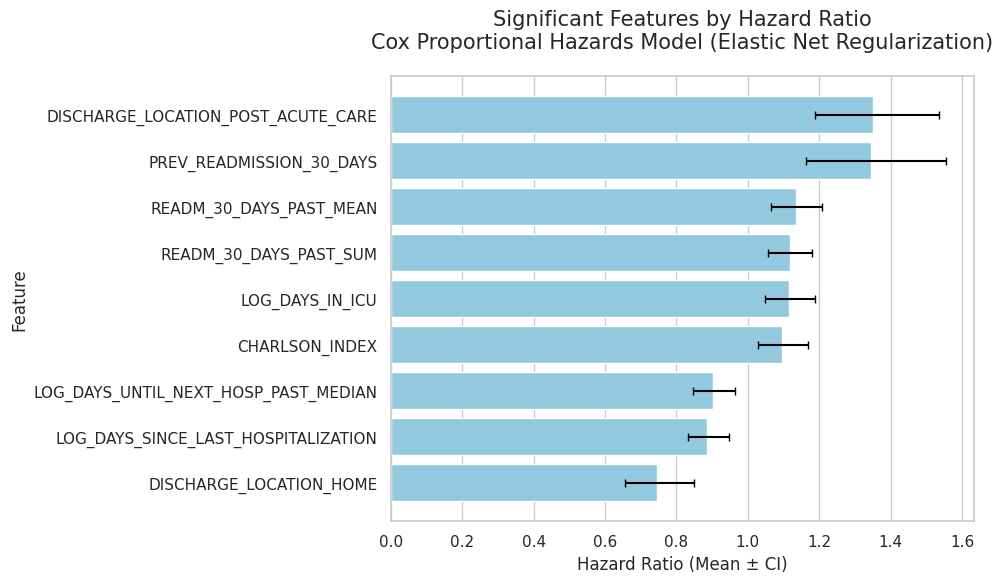

In [58]:
significant_features_df = pd.DataFrame({
    'feature': significant_features,
    'coef': coefs_significant_features,
    'hazard_ratio': hr_significant_features,
    'p_value': pvalue_significant_features,
    'ci_lower_hr': ci_lower_hr_significant_features,
    'ci_upper_hr': ci_upper_hr_significant_features
})
significant_features_df = significant_features_df.sort_values(by='hazard_ratio', ascending=False)

fig = plot_significant_coef_hr(significant_features_df)
fig.savefig(os.path.join(eda_plots_path, 'coxph_significant_features_hazard_ratio.png'), bbox_inches='tight', dpi=500)

### Clustering Analysis

In [41]:
period = 365 # days
readmissions_within_period_df = last_events_df[last_events_df['DAYS_UNTIL_NEXT_HOSPITALIZATION'] < period].copy()

In [42]:
print(f"Number of readmissions within the period: {len(readmissions_within_period_df)}")
readmissions_within_period_df[['DAYS_UNTIL_NEXT_HOSPITALIZATION', 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION']].describe()

Number of readmissions within the period: 1001


DAYS_UNTIL_NEXT_HOSPITALIZATION  LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION
count                      1001.000000                          1001.000000
mean                         89.273246                             3.883279
std                          91.652137                             1.234436
min                           2.075000                             1.123305
25%                          18.960417                             2.993751
50%                          53.470833                             3.997665
75%                         133.087500                             4.898493
max                         362.674306                             5.896259

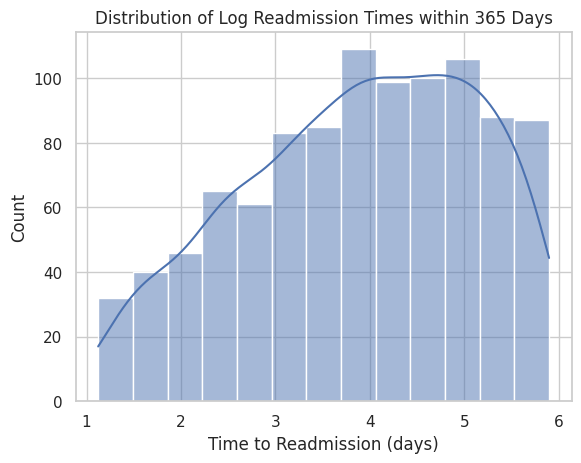

In [43]:
sns.histplot(readmissions_within_period_df['LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION'], kde=True)
plt.title(f"Distribution of Log Readmission Times within {period} Days")
plt.xlabel("Time to Readmission (days)")
plt.ylabel("Count")
plt.show()

In [44]:
readmissions_within_period_df['QUANTILE_DURATION_BIN'], bin_intervals = pd.qcut(readmissions_within_period_df['LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION'], q=3, labels=['Q1', 'Q2', 'Q3'], retbins=True)
bin_intervals = [round(np.expm1x(x).item(), 2) for x in bin_intervals]
bin_intervals

[2.07, 27.23, 99.13, 362.67]

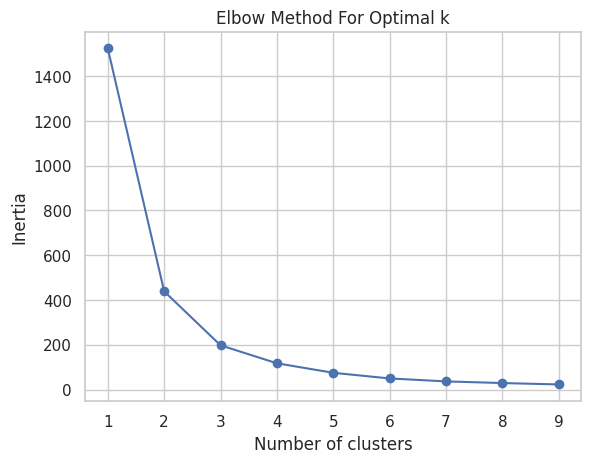

In [45]:
from sklearn.cluster import KMeans

X = readmissions_within_period_df['LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION'].dropna().values.reshape(-1, 1)
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(K, inertias, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

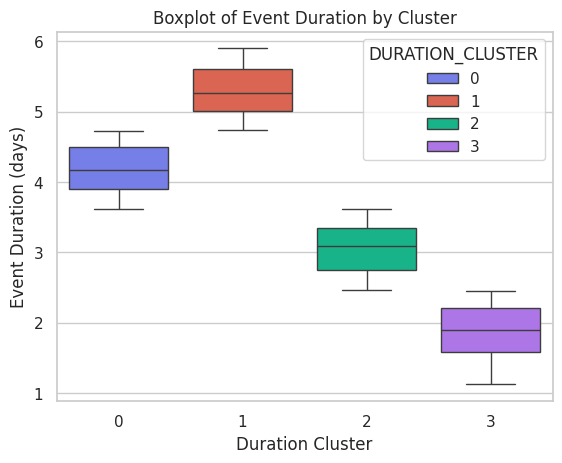

/tmp/ipykernel_8065/4214145269.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



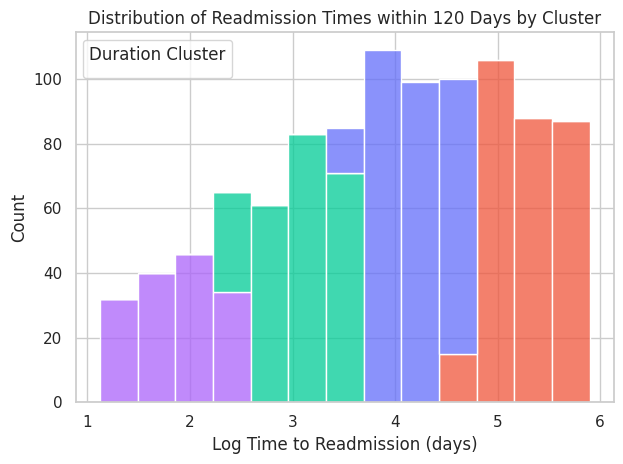

Cluster 0: min=3.617726513260784, max=4.723823213462192
Cluster 1: min=4.737349101928207, max=5.896258702138367
Cluster 2: min=2.4644440825571348, max=3.615113303874327
Cluster 3: min=1.123304901258481, max=2.4497471232856274
Cluster centers: [[4.1763899 ]
 [5.29690977]
 [3.05745315]
 [1.8602241 ]]


In [46]:
from sklearn.cluster import KMeans
import numpy as np
n_clusters = 4
# Reshape needed for KMeans
X = readmissions_within_period_df['LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION'].dropna().values.reshape(-1, 1)
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
readmissions_within_period_df.loc[:, 'DURATION_CLUSTER'] = kmeans.labels_

sns.boxplot(data=readmissions_within_period_df,
    x='DURATION_CLUSTER',
    y='LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION',
    hue='DURATION_CLUSTER',
    palette=px.colors.qualitative.Plotly[:n_clusters])
plt.title("Boxplot of Event Duration by Cluster")
plt.xlabel("Duration Cluster")
plt.ylabel("Event Duration (days)")
plt.show()

sns.histplot(
    data=readmissions_within_period_df,
    x="LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION",
    hue='DURATION_CLUSTER',
    palette=px.colors.qualitative.Plotly[:n_clusters],
    multiple="stack"
)
plt.title("Distribution of Readmission Times within 120 Days by Cluster")
plt.xlabel("Log Time to Readmission (days)")
plt.ylabel("Count")
plt.legend(title="Duration Cluster")
plt.tight_layout()
plt.show()

cluster_ranges_list = []
for i in range(kmeans.n_clusters):
    cluster_range = X[kmeans.labels_ == i]
    cluster_ranges_list.append([cluster_range.min(), cluster_range.max()])
    print(f"Cluster {i}: min={cluster_range.min()}, max={cluster_range.max()}")
print(f"Cluster centers: {kmeans.cluster_centers_}")

In [47]:
np.expm1x(cluster_ranges_list)

array([[ 36.25277778, 111.59791667],
       [113.13125   , 362.67430556],
       [ 10.75694444,  36.15555556],
       [  2.075     ,  10.58541667]])

/tmp/ipykernel_8065/2045070843.py:30: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Performing Kruskal-Wallis H-test for QUANTILE_DURATION_BIN...
                                      H_statistic   p_value  significant
LOG_HOSPITALIZATION_DAYS                16.268478  0.006118         True
LOG_DAYS_IN_ICU                         20.791881  0.000887         True
NUM_COMORBIDITIES                        5.151565  0.397665        False
NUM_PROCEDURES                          13.783192  0.017047         True
CHARLSON_INDEX                           7.087323  0.214227        False
NUM_PREV_HOSPITALIZATIONS                3.732182  0.588582        False
NUM_DRUGS                               14.931414  0.010659         True
READM_30_DAYS_PAST_MEAN                 23.205333  0.000308         True
READM_30_DAYS_PAST_SUM                  20.440774  0.001033         True
LOG_DAYS_SINCE_LAST_HOSPITALIZATION     30.622970  0.000011         True
LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN      21.802505  0.000571         True
LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN    21.277598  0.000718   

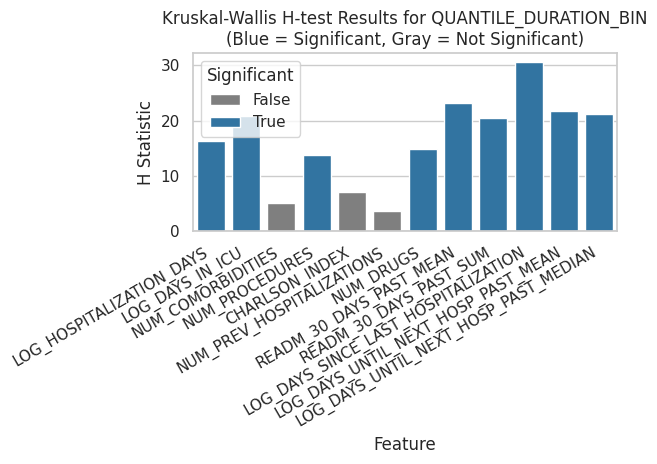

Performing Kruskal-Wallis H-test for DURATION_CLUSTER...
                                      H_statistic   p_value  significant
LOG_HOSPITALIZATION_DAYS                16.268478  0.006118         True
LOG_DAYS_IN_ICU                         20.791881  0.000887         True
NUM_COMORBIDITIES                        5.151565  0.397665        False
NUM_PROCEDURES                          13.783192  0.017047         True
CHARLSON_INDEX                           7.087323  0.214227        False
NUM_PREV_HOSPITALIZATIONS                3.732182  0.588582        False
NUM_DRUGS                               14.931414  0.010659         True
READM_30_DAYS_PAST_MEAN                 23.205333  0.000308         True
READM_30_DAYS_PAST_SUM                  20.440774  0.001033         True
LOG_DAYS_SINCE_LAST_HOSPITALIZATION     30.622970  0.000011         True
LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN      21.802505  0.000571         True
LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN    21.277598  0.000718        

/tmp/ipykernel_8065/2045070843.py:30: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



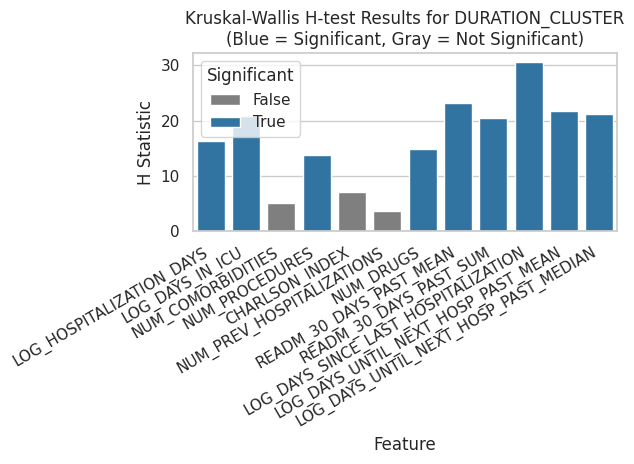

In [48]:
from scipy.stats import kruskal

# Define the features to test
features_to_test = [
    'LOG_HOSPITALIZATION_DAYS',
    'LOG_DAYS_IN_ICU',
    'NUM_COMORBIDITIES',
    'NUM_PROCEDURES',
    'CHARLSON_INDEX',
    'NUM_PREV_HOSPITALIZATIONS',
    'NUM_DRUGS',
    'READM_30_DAYS_PAST_MEAN',
    'READM_30_DAYS_PAST_SUM',
    'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
    'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
    'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
]

# Initialize a dictionary to store results
kruskal_results = {}

group_col = ['QUANTILE_DURATION_BIN', 'DURATION_CLUSTER']


for col in group_col:
    print(f"Performing Kruskal-Wallis H-test for {col}...")

    # Perform the Kruskal-Wallis H-test for each feature
    for feature in features_to_test:
        groups = [group[feature].dropna() for _, group in readmissions_within_period_df.groupby(group_col)]
        H, p = kruskal(*groups)
        kruskal_results[feature] = {"H_statistic": H, "p_value": p}

    # Convert results to a DataFrame for better visualization
    kruskal_results_df = pd.DataFrame.from_dict(kruskal_results, orient='index')
    kruskal_results_df['significant'] = kruskal_results_df['p_value'] < 0.05

    print(kruskal_results_df)
    sns.barplot(
        data=kruskal_results_df.reset_index(),
        x='index',
        y='H_statistic',
        hue='significant',
        palette={True: 'tab:blue', False: 'tab:gray'}
    )
    plt.axhline(0, color='black', linewidth=0.8)
    plt.title(f"Kruskal-Wallis H-test Results for {col}\n(Blue = Significant, Gray = Not Significant)")
    plt.ylabel("H Statistic")
    plt.xlabel("Feature")
    plt.legend(title='Significant')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

## Historical Events

In [10]:
print("Number of unique patients in historical_events_df:", historical_events_df['SUBJECT_ID'].nunique())

Number of unique patients in historical_events_df: 1610


In [14]:
historical_events_df['AT_LEAST_ONE_LONG_GAP'] = historical_events_df.groupby('SUBJECT_ID')['DAYS_UNTIL_NEXT_HOSPITALIZATION'].transform(lambda x: (x > 2*365).any())

In [15]:
mask = historical_events_df['AT_LEAST_ONE_LONG_GAP'] == True

In [16]:
print("Number of patients in total: ", historical_events_df['SUBJECT_ID'].nunique())
print("Number of patients with at least one very long gap: ", historical_events_df[mask]['SUBJECT_ID'].nunique())


Number of patients in total:  1610
Number of patients with at least one very long gap:  504


In [ ]:
from recurrent_health_events_prediction.preprocessing.utils import (
    remap_discharge_location,
    remap_mimic_races,
    one_hot_encode_and_drop,
)

historical_events_df = remap_discharge_location(historical_events_df)
historical_events_df = remap_mimic_races(historical_events_df)

features_to_encode = ['GENDER', 'INSURANCE', 'ADMISSION_TYPE', 'ETHNICITY', 'DISCHARGE_LOCATION']
one_hot_cols_to_drop = ['GENDER_F', 'INSURANCE_SELF_PAY', 'ADMISSION_TYPE_EMERGENCY', 'ETHNICITY_OTHER', 'DISCHARGE_LOCATION_OTHERS']
historical_events_df, new_features = one_hot_encode_and_drop(historical_events_df, features_to_encode, one_hot_cols_to_drop)

In [12]:
print("New features after one-hot encoding:")
new_features = sorted(new_features)
for feature in new_features:
    print(feature)

New features after one-hot encoding:
ADMISSION_TYPE_ELECTIVE
ADMISSION_TYPE_URGENT
DISCHARGE_LOCATION_HOME
DISCHARGE_LOCATION_POST_ACUTE_CARE
ETHNICITY_BLACK
ETHNICITY_HISPANIC
ETHNICITY_WHITE
GENDER_M
INSURANCE_GOVERNMENT
INSURANCE_MEDICAID
INSURANCE_MEDICARE
INSURANCE_PRIVATE


In [13]:
historical_events_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'HOSPITALIZATION_DAYS', 'NUM_COMORBIDITIES', 'TYPES_COMORBIDITIES',
       'HAS_DIABETES', 'HAS_COPD', 'HAS_CONGESTIVE_HF', 'NEXT_ADMISSION_TYPE',
       'NUM_PREV_HOSPITALIZATIONS', 'PREV_DISCHTIME', 'NEXT_ADMITTIME',
       'DAYS_SINCE_LAST_HOSPITALIZATION', 'DAYS_UNTIL_NEXT_HOSPITALIZATION',
       'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
       'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD', 'TOTAL_HOSPITALIZATIONS',
       'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'DOB', 'DOD', 'DOD_HOSP',
       'AGE', 'CHARLSON_INDEX', 'FIRST_ADMITTIME', 'LAST_DISCHTIME',
       'PARTICIPATION_DAYS', 'TOTAL_PARTICIPATION_DAYS',
       'DEATH_TIME_AFTER_LAST_DISCHARGE', 'READMISSION_EVENT',
      

<Figure size 1000x3000 with 0 Axes>

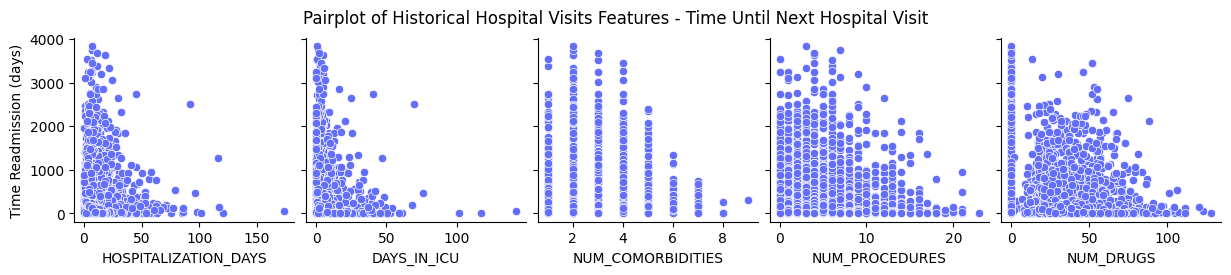

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 30))
variables = ['HOSPITALIZATION_DAYS', 'DAYS_IN_ICU', 'NUM_COMORBIDITIES', 'NUM_PROCEDURES', 'NUM_DRUGS']
y_var = 'DAYS_UNTIL_NEXT_HOSPITALIZATION'
pair_grid = sns.pairplot(historical_events_df[variables + [y_var]], diag_kind='kde', markers='o', height=2.5, x_vars=variables, y_vars=y_var)
for axis in pair_grid.axes.flatten():
    axis.set_ylabel('Time Readmission (days)')

plt.suptitle('Pairplot of Historical Hospital Visits Features - Time Until Next Hospital Visit', y=1.06)
plt.show()

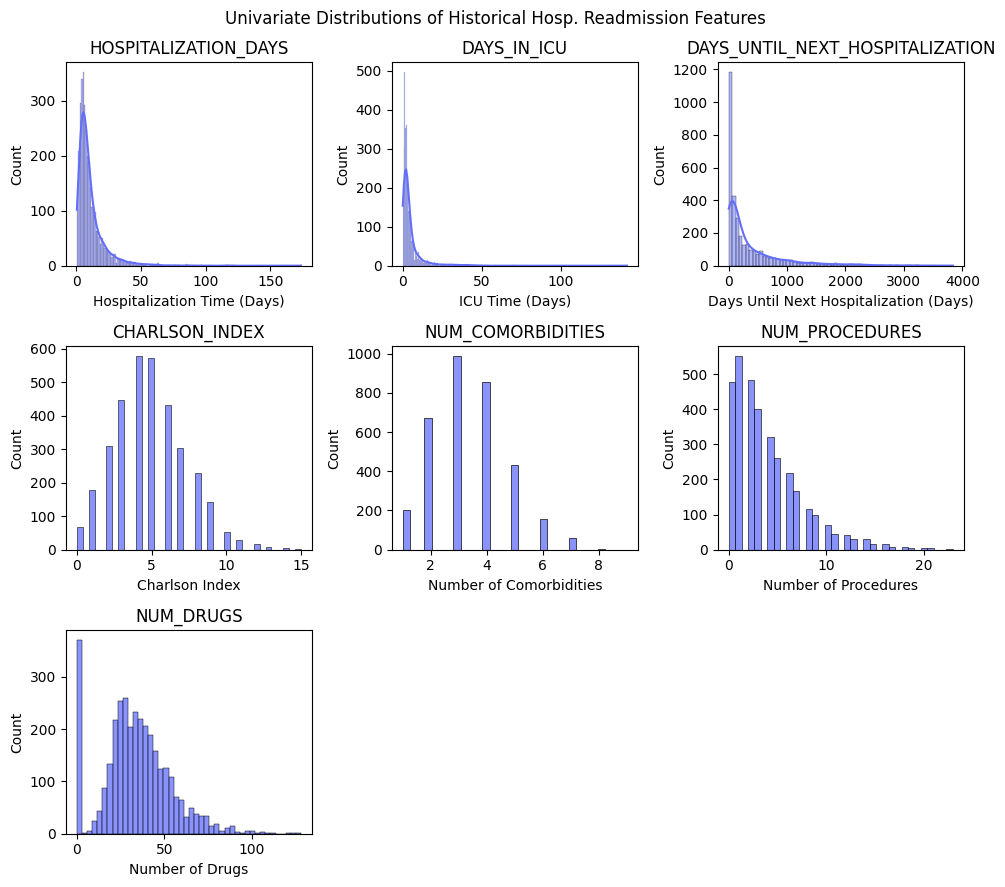

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_plot = ['HOSPITALIZATION_DAYS', 'DAYS_IN_ICU', 'DAYS_UNTIL_NEXT_HOSPITALIZATION', 'CHARLSON_INDEX', 'NUM_COMORBIDITIES', 'NUM_PROCEDURES', 'NUM_DRUGS']
col_kde = ['HOSPITALIZATION_DAYS', 'DAYS_IN_ICU', 'DAYS_UNTIL_NEXT_HOSPITALIZATION']
xlabels = ['Hospitalization Time (Days)', 'ICU Time (Days)', 'Days Until Next Hospitalization (Days)', 'Charlson Index', 'Number of Comorbidities', 'Number of Procedures', 'Number of Drugs']

n_cols = 3
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 9))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(historical_events_df[col].dropna(), kde=(col in col_kde), ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(xlabels[i] if i < len(xlabels) else col)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(len(columns_to_plot), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.suptitle('Univariate Distributions of Historical Hosp. Readmission Features')
plt.tight_layout()
plt.savefig("historical_events_distribution.png", bbox_inches='tight')
plt.show()

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
import numpy as np

columns_to_plot = [
    'LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'LOG_NUM_DRUGS',
]

col_kde = ['LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'LOG_NUM_DRUGS']
titles = [
    "Hospitalization Days in Log Scale",
    "Days in ICU in Log Scale",
    "Days Until Next Hospitalization in Log Scale",
    "Number of Drugs in Log Scale",
]

n_cols = 2
n_rows = 2

# Create subplot layout with secondary_y=True for each subplot
specs = [[{"secondary_y": True} for _ in range(n_cols)] for _ in range(n_rows)]

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    subplot_titles=titles,
    specs=specs,
    vertical_spacing=0.2,
)


for i, col in enumerate(columns_to_plot):
    row = (i // n_cols) + 1
    col_idx = (i % n_cols) + 1
    
    data = historical_events_df[col].dropna()
    threshold = data.quantile(0.98)
    filtered_data = data[data <= threshold]
    
    # Histogram
    fig.add_trace(
        go.Histogram(x=filtered_data, name=col, marker_color=plotly_colors[0], showlegend=False),
        row=row, col=col_idx, secondary_y=False
    )
    
    # KDE overlay if in col_kde
    if col in col_kde and len(filtered_data) > 1:
        kde = gaussian_kde(filtered_data)
        # Get rows up to the 97th percentile
        x_range = np.linspace(filtered_data.min(), filtered_data.max(), 200)
        y_kde = kde(x_range) * len(data) * (x_range[1] - x_range[0])  # scale KDE to match histogram
        
        fig.add_trace(
            go.Scatter(x=x_range, y=y_kde, mode='lines', name=f"{col} KDE", line=dict(color='darkblue')),
            row=row, col=col_idx, secondary_y=True
        )

    # Custom x-axis label
    fig.update_xaxes(title_text="Value", row=row, col=col_idx)
    fig.update_yaxes(title_text="Count", row=row, col=col_idx)
    fig.update_yaxes(title_text="Density", row=row, col=col_idx, secondary_y=True)


# Remove unused subplot if any
total_subplots = n_rows * n_cols
for j in range(len(columns_to_plot), total_subplots):
    row = (j // n_cols) + 1
    col_idx = (j % n_cols) + 1
    fig.update_xaxes(visible=False, row=row, col=col_idx)
    fig.update_yaxes(visible=False, row=row, col=col_idx)

# Layout
fig.update_layout(
    height=700, width=1300,
    title=dict(
        text="Univariate Distributions of Numerical Continuous Variables in Log Scale - Historical Hospital Readmissions",
        font=dict(size=20),
        x=0.5,
        y=1.0,  # Adjust y to move title up
        xanchor='center',
        yanchor='top',
        pad=dict(t=30,)  # Add top padding to create a margin
    ),
    showlegend=False,
    template='simple_white'
)
filepath = os.path.join(eda_plots_path, "historical_events_log_numerical_distributions_plotly.html")
fig.write_html(filepath)
for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.03  # Adjust the amount as needed (0.02–0.05 usually works well)
fig.show()


In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
import numpy as np

columns_to_plot = [
    'CHARLSON_INDEX', 'NUM_COMORBIDITIES', 'NUM_PROCEDURES', 'NUM_DRUGS'
]

col_kde = []
titles = [
    'Charlson Index', 'Number of Comorbidities', 'Number of Procedures', 'Number of Drugs'
]

n_cols = 2
n_rows = 2
fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=titles)

for i, col in enumerate(columns_to_plot):
    row = (i // n_cols) + 1
    col_idx = (i % n_cols) + 1
    
    data = historical_events_df[col].dropna()
    
    # Histogram
    fig.add_trace(
        go.Histogram(x=data, name=col, marker_color=plotly_colors[0], showlegend=False),
        row=row, col=col_idx
    )
    
    # KDE overlay if in col_kde
    if col in col_kde and len(data) > 1:
        kde = gaussian_kde(data)
        x_range = np.linspace(data.min(), data.max(), 200)
        y_kde = kde(x_range) * len(data) * (x_range[1] - x_range[0])  # scale KDE to match histogram
        
        fig.add_trace(
            go.Scatter(x=x_range, y=y_kde, mode='lines', name=f"{col} KDE", line=dict(color='darkblue')),
            row=row, col=col_idx
        )

    # Custom x-axis label
    fig.update_xaxes(title_text="Value", row=row, col=col_idx)
    fig.update_yaxes(title_text="Count", row=row, col=col_idx)

# Remove unused subplot if any
total_subplots = n_rows * n_cols
for j in range(len(columns_to_plot), total_subplots):
    row = (j // n_cols) + 1
    col_idx = (j % n_cols) + 1
    fig.update_xaxes(visible=False, row=row, col=col_idx)
    fig.update_yaxes(visible=False, row=row, col=col_idx)

# Layout
fig.update_layout(
    height=700, width=1000,
    title=dict(
        text="Univariate Distributions of Numerical Discrete Variables in Historical Hospital Readmissions",
        font=dict(size=20),
        pad=dict(t=20, b=10),  # Add top padding to create a margin
        x=0.5,
        y=0.97
    ),
    showlegend=False,
    template='simple_white',
)
filepath = os.path.join(eda_plots_path, "historical_events_discrete_distributions_plotly.html")
fig.write_html(filepath)
fig.show()


In [18]:
from recurrent_health_events_prediction.eda.utils import get_main_metrics_specific_cols

get_main_metrics_specific_cols(historical_events_df, columns_to_plot, metrics=['mean', 'median', 'kurtosis', 'skew'])

Metric  CHARLSON_INDEX  NUM_COMORBIDITIES  NUM_PROCEDURES  NUM_DRUGS
0      mean           4.858              3.412           3.904     33.975
1    median           5.000              3.000           3.000     33.000
2  kurtosis           0.279              0.049           2.495      0.857
3      skew           0.457              0.418           1.461      0.449

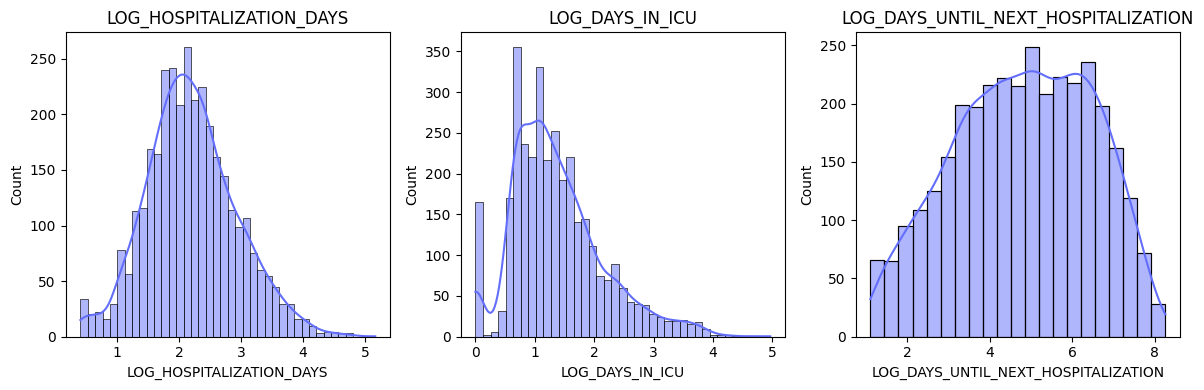

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_plot = ['LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION']

n_cols = 3
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(historical_events_df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(len(columns_to_plot), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


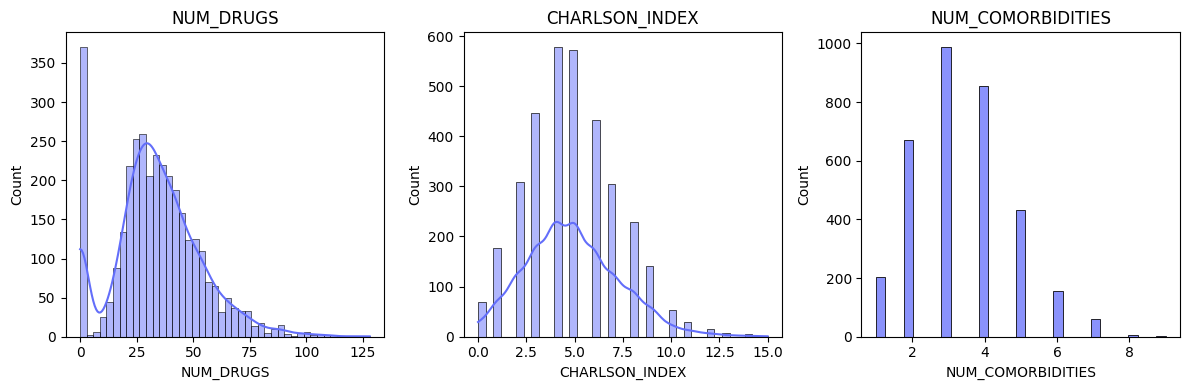

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_plot = ['NUM_DRUGS', 'CHARLSON_INDEX', 'NUM_COMORBIDITIES']

n_cols = 3
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    if col == 'NUM_COMORBIDITIES':
        kde = False
    else:
        kde = True
    sns.histplot(historical_events_df[col].dropna(), kde=kde, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(len(columns_to_plot), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [21]:
from recurrent_health_events_prediction.eda.utils import get_main_metrics_specific_cols

get_main_metrics_specific_cols(historical_events_df, columns_to_plot, metrics=['mean', 'median', 'kurtosis', 'skew'])

Metric  NUM_DRUGS  CHARLSON_INDEX  NUM_COMORBIDITIES
0      mean     33.975           4.858              3.412
1    median     33.000           5.000              3.000
2  kurtosis      0.857           0.279              0.049
3      skew      0.449           0.457              0.418

In [22]:
historical_events_df['LOG_NUM_DRUGS'] = np.log1p(historical_events_df['NUM_DRUGS'])

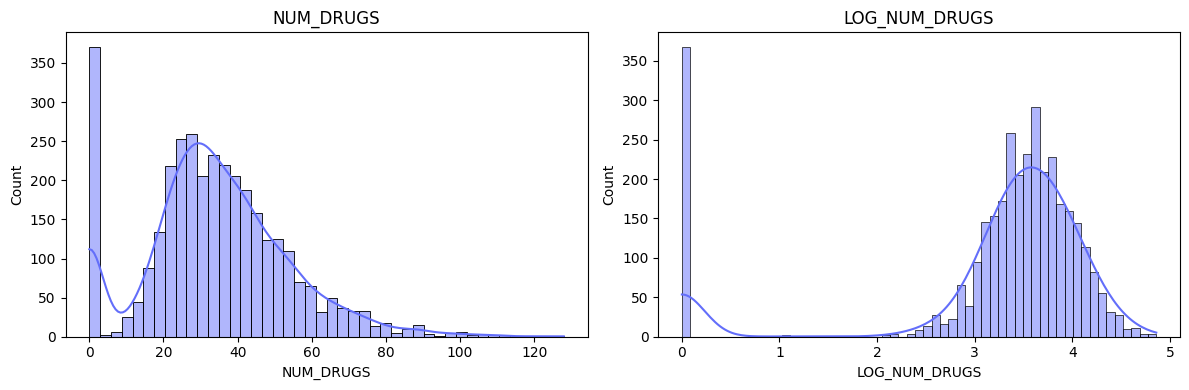

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

columns_to_plot = ['NUM_DRUGS', 'LOG_NUM_DRUGS']

n_cols = 2
n_rows = 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(historical_events_df[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Hide any unused subplots
for j in range(len(columns_to_plot), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [24]:
from recurrent_health_events_prediction.eda.utils import get_main_metrics_specific_cols
filtered_df = historical_events_df[historical_events_df['NUM_DRUGS'] > 0]
get_main_metrics_specific_cols(filtered_df, columns_to_plot, metrics=['mean', 'median', 'kurtosis', 'skew'])

Metric  NUM_DRUGS  LOG_NUM_DRUGS
0      mean     38.132          3.579
1    median     35.000          3.584
2  kurtosis      1.879          1.617
3      skew      1.116         -0.405

### Analysing Outliers

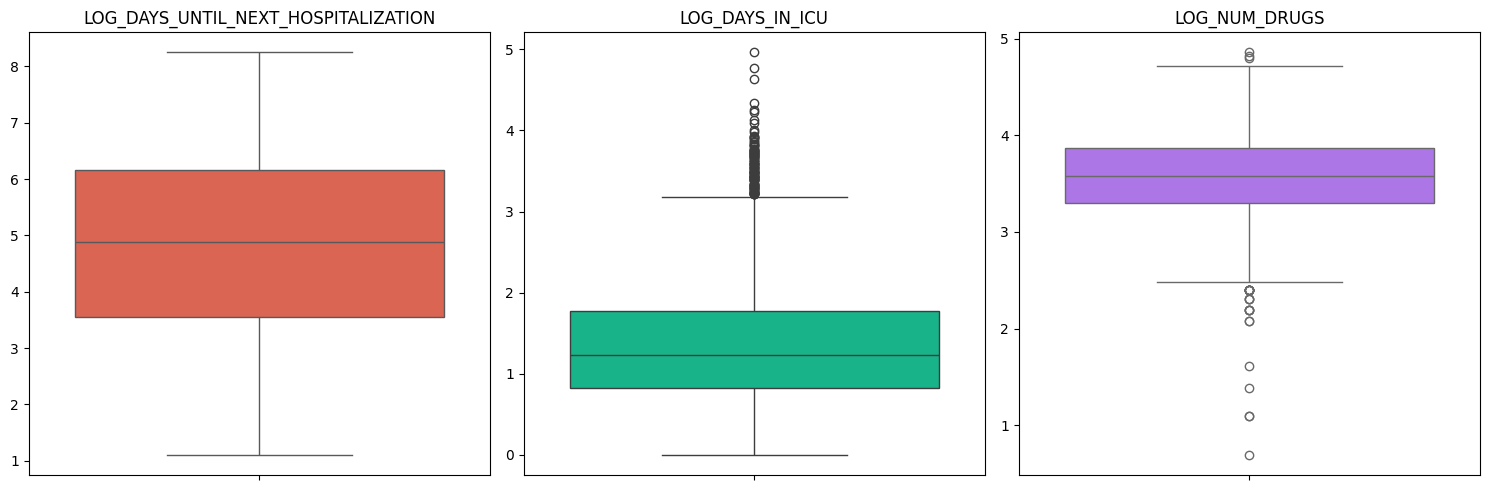

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust layout for horizontal arrangement
subplot = axes.flatten()  # Flatten the axes array for easier indexing

sns.boxplot(data=historical_events_df, y='LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', ax=subplot[0], color=plotly_colors[1])
subplot[0].set_title('LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION')
subplot[0].set_ylabel('')

sns.boxplot(data=historical_events_df, y='LOG_DAYS_IN_ICU', ax=subplot[1], color=plotly_colors[2])
subplot[1].set_title('LOG_DAYS_IN_ICU')
subplot[1].set_ylabel('')


hist_events_filtered = historical_events_df[historical_events_df['NUM_DRUGS'] > 0]
sns.boxplot(data=hist_events_filtered, y='LOG_NUM_DRUGS', ax=subplot[2], color=plotly_colors[3])
subplot[2].set_title('LOG_NUM_DRUGS')
subplot[2].set_ylabel('')

plt.tight_layout()
plt.show()

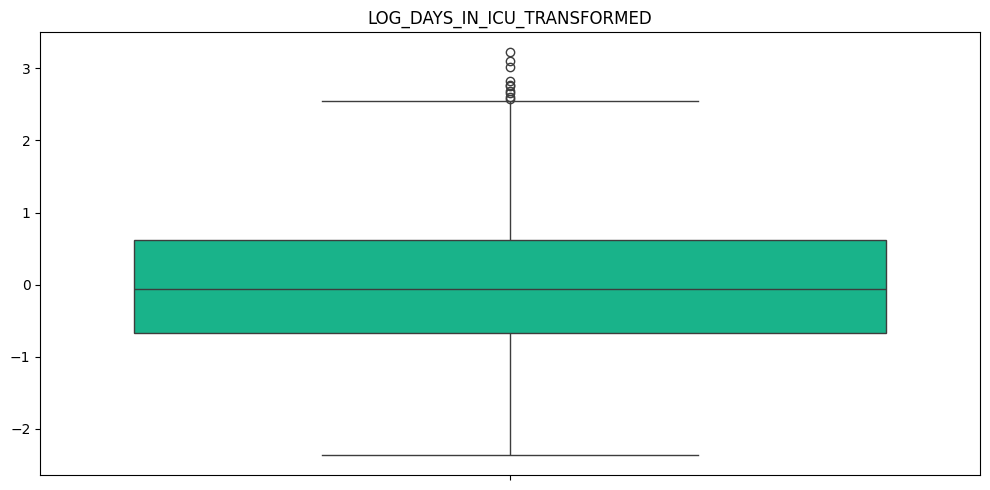

In [32]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
X_transformed = pt.fit_transform(historical_events_df[['LOG_DAYS_IN_ICU']])
X_transformed = pd.DataFrame(X_transformed, columns=['LOG_DAYS_IN_ICU_TRANSFORMED'])

plt.figure(figsize=(10, 5))
axes = sns.boxplot(data=X_transformed, y='LOG_DAYS_IN_ICU_TRANSFORMED', color=plotly_colors[2])
axes.set_title('LOG_DAYS_IN_ICU_TRANSFORMED')
axes.set_ylabel('')  # Corrected from plt.set_ylabel to axes.set_ylabel
plt.tight_layout()
plt.show()


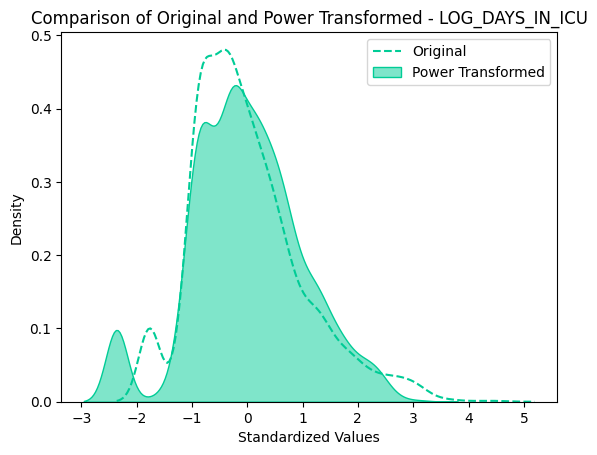

In [35]:
mean_orig = historical_events_df['LOG_DAYS_IN_ICU'].mean()
std_orig = historical_events_df['LOG_DAYS_IN_ICU'].std()

orig_standardized = (historical_events_df['LOG_DAYS_IN_ICU'] - mean_orig) / std_orig
trans_standardized = X_transformed['LOG_DAYS_IN_ICU_TRANSFORMED']  # already standardized

sns.kdeplot(orig_standardized.dropna(), linestyle='--', label='Original', color=plotly_colors[2])
sns.kdeplot(trans_standardized.dropna(), fill=True, alpha=0.5, label='Power Transformed', color=plotly_colors[2])
plt.title('Comparison of Original and Power Transformed - LOG_DAYS_IN_ICU')
plt.xlabel('Standardized Values')
plt.ylabel('Density')
plt.legend()


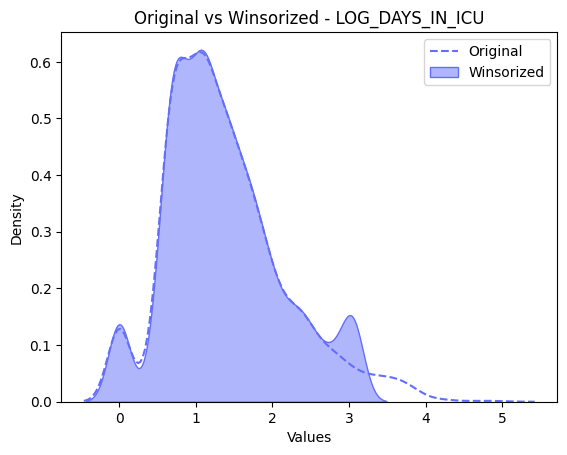

In [36]:
from scipy.stats.mstats import winsorize
import numpy as np

log_days_in_icu_s = historical_events_df['LOG_DAYS_IN_ICU'].copy()

# Winsorize at 1% on both ends (can adjust)
winsorized_data = winsorize(log_days_in_icu_s, limits=[0, 0.04])

# Compare distributions
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(historical_events_df['LOG_DAYS_IN_ICU'], linestyle='--', label='Original')
sns.kdeplot(winsorized_data, fill=True, alpha=0.5, label='Winsorized')
plt.title('Original vs Winsorized - LOG_DAYS_IN_ICU')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.show()


### Selection Emisison Variables

In [25]:
n_measurements_per_person = historical_events_df.groupby('SUBJECT_ID').size()
print("Distribution of measurements per person:")
print(n_measurements_per_person.describe())

Distribution of measurements per person:
count    1610.000000
mean        2.096894
std         2.005723
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        22.000000
dtype: float64


#### Mutual Information Analysis

**🔍 Feature Selection using Mutual Information (MI)**

In this analysis, we want to identify which features (emission variables) are most informative for predicting the target variable: **`LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION`**.

**What is Mutual Information?**

**Mutual Information (MI)** measures the amount of information one variable provides about another. It captures **both linear and non-linear dependencies** between variables.

- High MI means knowing the value of one variable reduces uncertainty about the other.
- MI is particularly useful when relationships between features and the target are not strictly linear.

**Why Use MI for Feature Selection?**

In the context of Hidden Markov Models (HMMs), selecting emission variables that are **informative about the target variable** can help improve:
- The **quality of inferred hidden states**,
- The **prediction of masked variables** (like in our final time step),
- And reduce unnecessary noise in the model.

**How We Use MI**

We compute mutual information between each **candidate emission variable** (e.g., `NUM_PROCEDURES`, `CHARLSON_INDEX`, etc.) and the **target emission variable** `LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION`

This allows us to **quantitatively assess** which variables are most relevant, without relying on exhaustive testing of variable combinations.


In [26]:
new_features

['ADMISSION_TYPE_ELECTIVE',
 'ADMISSION_TYPE_URGENT',
 'DISCHARGE_LOCATION_HOME',
 'DISCHARGE_LOCATION_POST_ACUTE_CARE',
 'ETHNICITY_BLACK',
 'ETHNICITY_HISPANIC',
 'ETHNICITY_WHITE',
 'GENDER_M',
 'INSURANCE_GOVERNMENT',
 'INSURANCE_MEDICAID',
 'INSURANCE_MEDICARE',
 'INSURANCE_PRIVATE']

In [27]:
add_emission_candidates = [
    'LOG_HOSPITALIZATION_DAYS', 'LOG_DAYS_IN_ICU', 'CHARLSON_INDEX',
    'NUM_PROCEDURES', 'NUM_DRUGS', 'PREV_READMISSION_30_DAYS', 'HAS_DIABETES',
    'HAS_COPD', 'HAS_CONGESTIVE_HF', 'NUM_COMORBIDITIES', 'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
] + new_features

historical_events_df[add_emission_candidates].describe()

LOG_HOSPITALIZATION_DAYS  LOG_DAYS_IN_ICU  CHARLSON_INDEX  \
count               3376.000000      3376.000000      3376.00000   
mean                   2.203074         1.376574         4.85782   
std                    0.724825         0.778584         2.42797   
min                    0.405465         0.000000         0.00000   
25%                    1.740618         0.820505         3.00000   
50%                    2.158843         1.231576         5.00000   
75%                    2.644388         1.775209         6.00000   
max                    5.163297         4.963025        15.00000   

       NUM_PROCEDURES    NUM_DRUGS  PREV_READMISSION_30_DAYS  \
count     3376.000000  3376.000000               3376.000000   
mean         3.904325    33.975415                 -0.359597   
std          3.681147    19.687898                  0.681925   
min          0.000000     0.000000                 -1.000000   
25%          1.000000    23.000000                 -1.000000   
50%          3.000000    33.000000                  0.000000   
75%          6.000000    45.000000                  0.000000   
max         23.000000   128.000000                  1.000000   

       NUM_COMORBIDITIES  LOG_DAYS_SINCE_LAST_HOSPITALIZATION  
count        3376.000000                          1766.000000  
mean            3.411730                             4.768973  
std             1.342159                             1.618074  
min             1.000000                             1.103001  
25%             2.000000                             3.591172  
50%             3.000000                             4.838280  
75%             4.000000                             6.049680  
max             9.000000                             8.215537

In [28]:
historical_events_copy_df = historical_events_df.copy()
historical_events_copy_df['PREV_READMISSION_30_DAYS'] = np.where(
    historical_events_copy_df['PREV_READMISSION_30_DAYS'] == -1, 0, historical_events_copy_df['PREV_READMISSION_30_DAYS']
)
median_log_days_since_last_hospitalization = historical_events_copy_df['LOG_DAYS_SINCE_LAST_HOSPITALIZATION'].median()
historical_events_copy_df['LOG_DAYS_SINCE_LAST_HOSPITALIZATION'] = historical_events_copy_df['LOG_DAYS_SINCE_LAST_HOSPITALIZATION'].fillna(median_log_days_since_last_hospitalization)
historical_events_copy_df['RANDOM_FEATURE'] = np.random.rand(len(historical_events_copy_df))

historical_events_copy_df[add_emission_candidates].describe()

LOG_HOSPITALIZATION_DAYS  LOG_DAYS_IN_ICU  CHARLSON_INDEX  \
count               3376.000000      3376.000000      3376.00000   
mean                   2.203074         1.376574         4.85782   
std                    0.724825         0.778584         2.42797   
min                    0.405465         0.000000         0.00000   
25%                    1.740618         0.820505         3.00000   
50%                    2.158843         1.231576         5.00000   
75%                    2.644388         1.775209         6.00000   
max                    5.163297         4.963025        15.00000   

       NUM_PROCEDURES    NUM_DRUGS  PREV_READMISSION_30_DAYS  \
count     3376.000000  3376.000000               3376.000000   
mean         3.904325    33.975415                  0.117299   
std          3.681147    19.687898                  0.321823   
min          0.000000     0.000000                  0.000000   
25%          1.000000    23.000000                  0.000000   
50%          3.000000    33.000000                  0.000000   
75%          6.000000    45.000000                  0.000000   
max         23.000000   128.000000                  1.000000   

       NUM_COMORBIDITIES  LOG_DAYS_SINCE_LAST_HOSPITALIZATION  
count        3376.000000                          3376.000000  
mean            3.411730                             4.802025  
std             1.342159                             1.170642  
min             1.000000                             1.103001  
25%             2.000000                             4.731843  
50%             3.000000                             4.838280  
75%             4.000000                             4.933921  
max             9.000000                             8.215537

In [29]:
from recurrent_health_events_prediction.eda.utils import get_mutual_info_scores


mi_results_log_time = get_mutual_info_scores(
    df=historical_events_copy_df,
    features=add_emission_candidates + ['RANDOM_FEATURE'],
    target_col='LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION',
    subject_id_col='SUBJECT_ID',
    regression=True,
    n_bootstraps=1000
)

Bootstrapping: 100%|██████████| 1000/1000 [01:18<00:00, 12.75it/s]


In [30]:
mi_results_log_time

Feature   MI_Mean  MI_Median    MI_Std  \
10  LOG_DAYS_SINCE_LAST_HOSPITALIZATION  0.033622   0.033814  0.011402   
4                             NUM_DRUGS  0.030521   0.030174  0.014162   
9                     NUM_COMORBIDITIES  0.026987   0.027025  0.012104   
1                       LOG_DAYS_IN_ICU  0.025970   0.025886  0.014136   
7                              HAS_COPD  0.020493   0.020387  0.008670   
2                        CHARLSON_INDEX  0.019979   0.019843  0.012154   
14   DISCHARGE_LOCATION_POST_ACUTE_CARE  0.015016   0.014785  0.008392   
22                    INSURANCE_PRIVATE  0.010200   0.010026  0.006611   
11              ADMISSION_TYPE_ELECTIVE  0.005976   0.005795  0.004634   
21                   INSURANCE_MEDICARE  0.006763   0.005541  0.006537   
5              PREV_READMISSION_30_DAYS  0.005329   0.004836  0.004507   
13              DISCHARGE_LOCATION_HOME  0.006726   0.004653  0.007124   
3                        NUM_PROCEDURES  0.008044   0.004478  0.009419   
17                      ETHNICITY_WHITE  0.005126   0.003575  0.005692   
15                      ETHNICITY_BLACK  0.004927   0.003025  0.005509   
20                   INSURANCE_MEDICAID  0.003431   0.002233  0.003751   
19                 INSURANCE_GOVERNMENT  0.001815   0.001436  0.001759   
0              LOG_HOSPITALIZATION_DAYS  0.006357   0.001292  0.008578   
12                ADMISSION_TYPE_URGENT  0.001400   0.000736  0.001676   
16                   ETHNICITY_HISPANIC  0.001311   0.000177  0.001862   
6                          HAS_DIABETES  0.003692   0.000154  0.005309   
18                             GENDER_M  0.000189   0.000000  0.001047   
8                     HAS_CONGESTIVE_HF  0.002878   0.000000  0.004612   
23                       RANDOM_FEATURE  0.000425   0.000000  0.002203   

    CI_Lower  CI_Upper  
10  0.011178  0.055626  
4   0.002992  0.059052  
9   0.003524  0.051601  
1   0.000000  0.056286  
7   0.003497  0.037445  
2   0.000000  0.044680  
14  0.000000  0.032949  
22  0.000000  0.023000  
11  0.000000  0.016109  
21  0.000000  0.020842  
5   0.000000  0.015615  
13  0.000000  0.023490  
3   0.000000  0.029920  
17  0.000000  0.019387  
15  0.000000  0.017870  
20  0.000000  0.012320  
19  0.000000  0.005907  
0   0.000000  0.028646  
12  0.000000  0.005620  
16  0.000000  0.006225  
6   0.000000  0.017587  
18  0.000000  0.002662  
8   0.000000  0.015943  
23  0.000000  0.006813

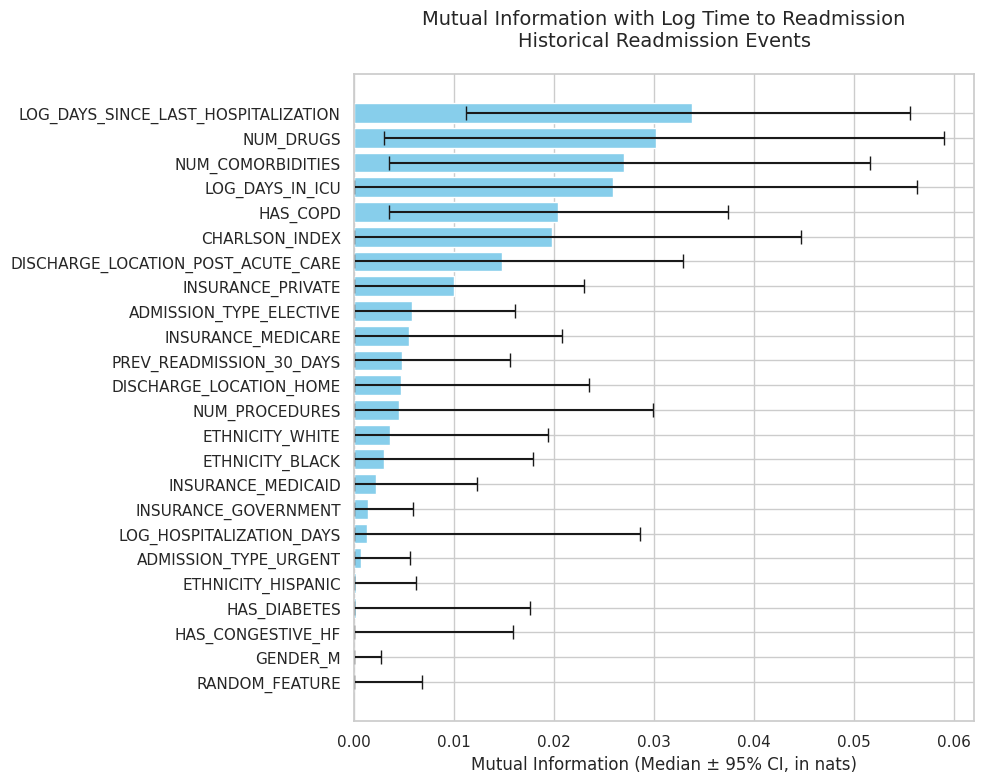

In [34]:
from recurrent_health_events_prediction.eda.utils import plot_mutual_information

fig = plot_mutual_information(mi_results_log_time, title='Mutual Information with Log Time to Readmission\nHistorical Readmission Events')
filepath = os.path.join(eda_plots_path, "historical_events_mutual_information_log_time.png")
fig.savefig(filepath,  dpi=500)

In [32]:
print(historical_events_copy_df['READMISSION_30_DAYS'].value_counts(normalize=True))

READMISSION_30_DAYS
0    0.771031
1    0.228969
Name: proportion, dtype: float64


In [33]:
target_col = 'READMISSION_30_DAYS'
print("Mutual Information Scores for Classification Target:")
mi_classification_results = get_mutual_info_scores(
    df=historical_events_copy_df,
    features=add_emission_candidates + ['RANDOM_FEATURE'],
    target_col=target_col,
    subject_id_col='SUBJECT_ID',
    regression=False,
    n_bootstraps=1000
)

Mutual Information Scores for Classification Target:


Bootstrapping: 100%|██████████| 1000/1000 [00:59<00:00, 16.69it/s]


In [35]:
mi_classification_results

Feature   MI_Mean  MI_Median    MI_Std  \
10  LOG_DAYS_SINCE_LAST_HOSPITALIZATION  0.012893   0.012500  0.007512   
1                       LOG_DAYS_IN_ICU  0.009517   0.009033  0.006725   
4                             NUM_DRUGS  0.006672   0.005446  0.006686   
5              PREV_READMISSION_30_DAYS  0.006296   0.004492  0.006716   
13              DISCHARGE_LOCATION_HOME  0.005876   0.003982  0.006410   
14   DISCHARGE_LOCATION_POST_ACUTE_CARE  0.005545   0.003302  0.006408   
9                     NUM_COMORBIDITIES  0.004566   0.002127  0.005903   
3                        NUM_PROCEDURES  0.004615   0.001981  0.005697   
8                     HAS_CONGESTIVE_HF  0.004372   0.001885  0.005594   
2                        CHARLSON_INDEX  0.004324   0.001539  0.005703   
17                      ETHNICITY_WHITE  0.004081   0.001530  0.005472   
23                       RANDOM_FEATURE  0.003723   0.001465  0.004758   
7                              HAS_COPD  0.004437   0.001208  0.005859   
21                   INSURANCE_MEDICARE  0.003988   0.000961  0.005505   
18                             GENDER_M  0.003767   0.000725  0.005307   
11              ADMISSION_TYPE_ELECTIVE  0.003753   0.000499  0.005222   
6                          HAS_DIABETES  0.003641   0.000452  0.005294   
16                   ETHNICITY_HISPANIC  0.003538   0.000244  0.005174   
15                      ETHNICITY_BLACK  0.003748   0.000107  0.005421   
22                    INSURANCE_PRIVATE  0.003538   0.000000  0.005161   
0              LOG_HOSPITALIZATION_DAYS  0.000782   0.000000  0.002052   
20                   INSURANCE_MEDICAID  0.003348   0.000000  0.005065   
19                 INSURANCE_GOVERNMENT  0.003358   0.000000  0.004837   
12                ADMISSION_TYPE_URGENT  0.003051   0.000000  0.004950   

    CI_Lower  CI_Upper  
10       0.0  0.030786  
1        0.0  0.024075  
4        0.0  0.022117  
5        0.0  0.022143  
13       0.0  0.022224  
14       0.0  0.021380  
9        0.0  0.020186  
3        0.0  0.019272  
8        0.0  0.018670  
2        0.0  0.019132  
17       0.0  0.017934  
23       0.0  0.015156  
7        0.0  0.019482  
21       0.0  0.018672  
18       0.0  0.017755  
11       0.0  0.016816  
6        0.0  0.017775  
16       0.0  0.016364  
15       0.0  0.017502  
22       0.0  0.017566  
0        0.0  0.007237  
20       0.0  0.016573  
19       0.0  0.016909  
12       0.0  0.016850

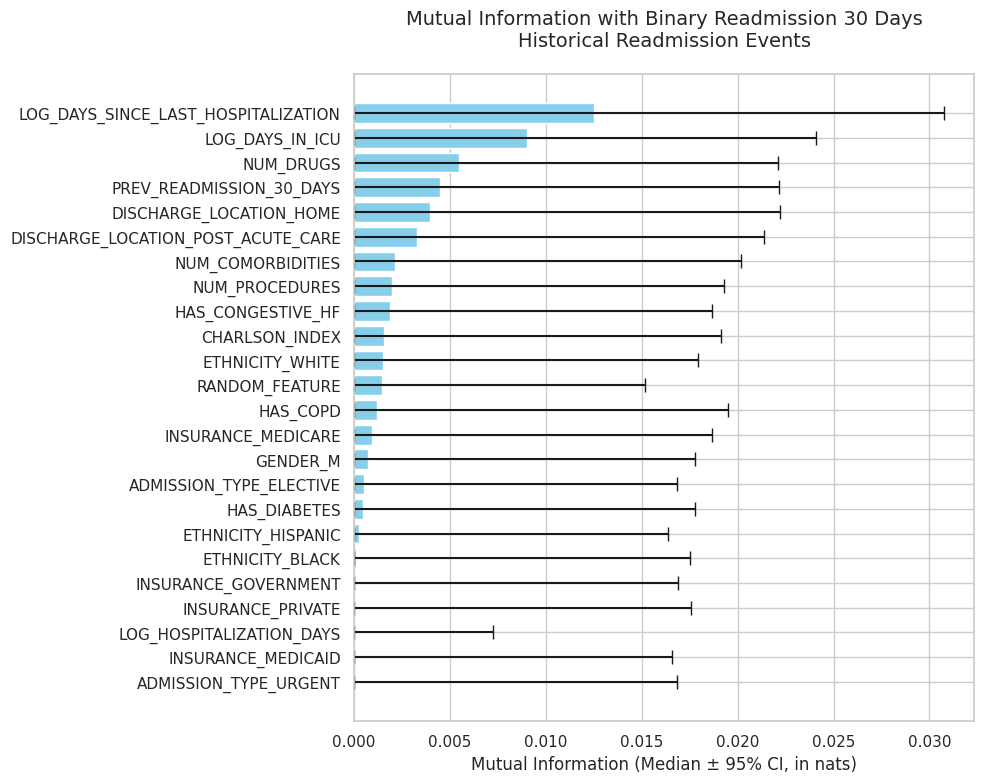

In [36]:
fig = plot_mutual_information(mi_classification_results, title='Mutual Information with Binary Readmission 30 Days\nHistorical Readmission Events')
filepath = os.path.join(eda_plots_path, "historical_events_mutual_information_binary_time.png")
fig.savefig(filepath,  dpi=500)

#### Random Forest Feature Importance

In [70]:
from recurrent_health_events_prediction.eda.utils import get_rf_importance_scores


target_col = 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION' # Regression target
importance_df = get_rf_importance_scores(
    df=historical_events_copy_df,
    features=add_emission_candidates + ['RANDOM_FEATURE'],
    target_col=target_col,
    subject_id_col='SUBJECT_ID',
    task_type='regression',
    importance_type='gini',
    n_bootstraps=100,
    random_state=42,
    n_jobs=-1,
    verbose=True
)
print("Feature Importances from Random Forest Regressor:")
importance_df

Bootstrapping: 100%|██████████| 100/100 [00:43<00:00,  2.27it/s]

Feature Importances from Random Forest Regressor:


feature  importance_mean  importance_median  \
1                       LOG_DAYS_IN_ICU         0.150776           0.150683   
23                       RANDOM_FEATURE         0.141392           0.141161   
0              LOG_HOSPITALIZATION_DAYS         0.133780           0.133890   
4                             NUM_DRUGS         0.128248           0.128702   
10  LOG_DAYS_SINCE_LAST_HOSPITALIZATION         0.108970           0.108905   
3                        NUM_PROCEDURES         0.066765           0.066559   
2                        CHARLSON_INDEX         0.066121           0.066104   
9                     NUM_COMORBIDITIES         0.041310           0.041090   
7                              HAS_COPD         0.017855           0.017677   
18                             GENDER_M         0.016337           0.016485   
8                     HAS_CONGESTIVE_HF         0.014581           0.014536   
6                          HAS_DIABETES         0.014368           0.014254   
11              ADMISSION_TYPE_ELECTIVE         0.013560           0.013568   
17                      ETHNICITY_WHITE         0.013560           0.013534   
14   DISCHARGE_LOCATION_POST_ACUTE_CARE         0.010711           0.010613   
21                   INSURANCE_MEDICARE         0.010377           0.010380   
13              DISCHARGE_LOCATION_HOME         0.010180           0.010083   
22                    INSURANCE_PRIVATE         0.010002           0.009983   
15                      ETHNICITY_BLACK         0.009780           0.009645   
20                   INSURANCE_MEDICAID         0.007505           0.007492   
12                ADMISSION_TYPE_URGENT         0.004878           0.004861   
16                   ETHNICITY_HISPANIC         0.004736           0.004662   
19                 INSURANCE_GOVERNMENT         0.003229           0.003229   
5              PREV_READMISSION_30_DAYS         0.000980           0.000992   

    importance_std  ci_lower  ci_upper  
1         0.005436  0.141848  0.162104  
23        0.004022  0.133578  0.148333  
0         0.004317  0.125625  0.141815  
4         0.006449  0.115338  0.141254  
10        0.005709  0.097939  0.119583  
3         0.002261  0.062646  0.070694  
2         0.002761  0.060835  0.071066  
9         0.002236  0.037820  0.045924  
7         0.001519  0.014896  0.021214  
18        0.000857  0.014519  0.017913  
8         0.000877  0.013280  0.016070  
6         0.000895  0.012853  0.016271  
11        0.001384  0.011237  0.016207  
17        0.001001  0.011972  0.015577  
14        0.000978  0.009164  0.012762  
21        0.000652  0.009206  0.011724  
13        0.000913  0.008541  0.011941  
22        0.000721  0.008852  0.011532  
15        0.000704  0.008526  0.011099  
20        0.000717  0.006136  0.008932  
12        0.000916  0.003107  0.006675  
16        0.000678  0.003683  0.006045  
19        0.000912  0.001668  0.005175  
5         0.000219  0.000565  0.001387

In [71]:
target_col = 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION' # Regression target
importance_df = get_rf_importance_scores(
    df=historical_events_copy_df,
    features=add_emission_candidates + ['RANDOM_FEATURE'],
    target_col=target_col,
    subject_id_col='SUBJECT_ID',
    task_type='regression',
    importance_type='permutation',
    n_bootstraps=100,
    random_state=42,
    n_jobs=-1,
    verbose=True
)
print("Feature Importances from Random Forest Regressor:")
importance_df

Bootstrapping: 100%|██████████| 100/100 [06:34<00:00,  3.94s/it]

Feature Importances from Random Forest Regressor:


feature  importance_mean  importance_median  \
4                             NUM_DRUGS         0.409104           0.409375   
10  LOG_DAYS_SINCE_LAST_HOSPITALIZATION         0.365054           0.366843   
1                       LOG_DAYS_IN_ICU         0.360822           0.357977   
0              LOG_HOSPITALIZATION_DAYS         0.248646           0.249564   
23                       RANDOM_FEATURE         0.235008           0.234192   
2                        CHARLSON_INDEX         0.156813           0.153194   
3                        NUM_PROCEDURES         0.148616           0.147067   
9                     NUM_COMORBIDITIES         0.102670           0.100136   
7                              HAS_COPD         0.072955           0.067149   
17                      ETHNICITY_WHITE         0.031762           0.029782   
18                             GENDER_M         0.029345           0.029063   
6                          HAS_DIABETES         0.029009           0.027772   
8                     HAS_CONGESTIVE_HF         0.027794           0.026550   
14   DISCHARGE_LOCATION_POST_ACUTE_CARE         0.026242           0.024300   
13              DISCHARGE_LOCATION_HOME         0.023879           0.022347   
11              ADMISSION_TYPE_ELECTIVE         0.021348           0.020931   
21                   INSURANCE_MEDICARE         0.015950           0.015861   
22                    INSURANCE_PRIVATE         0.016535           0.015534   
15                      ETHNICITY_BLACK         0.014555           0.013975   
20                   INSURANCE_MEDICAID         0.008921           0.008515   
12                ADMISSION_TYPE_URGENT         0.004859           0.004450   
16                   ETHNICITY_HISPANIC         0.003916           0.003900   
19                 INSURANCE_GOVERNMENT         0.002843           0.002504   
5              PREV_READMISSION_30_DAYS         0.000973           0.000950   

    importance_std  ci_lower  ci_upper  
4         0.033918  0.332713  0.478794  
10        0.031115  0.311405  0.421315  
1         0.036043  0.299584  0.428996  
0         0.017270  0.216872  0.283873  
23        0.013114  0.207761  0.260955  
2         0.025185  0.117702  0.220402  
3         0.021585  0.118610  0.204684  
9         0.025078  0.069329  0.158192  
7         0.027867  0.038509  0.148918  
17        0.009241  0.018324  0.053002  
18        0.004316  0.021894  0.038529  
6         0.005293  0.021476  0.040953  
8         0.005694  0.020985  0.038953  
14        0.007973  0.015001  0.044783  
13        0.007720  0.014077  0.042525  
11        0.004211  0.014996  0.029885  
21        0.002119  0.012505  0.020585  
22        0.004164  0.011174  0.026303  
15        0.002530  0.010525  0.019261  
20        0.002171  0.005706  0.014513  
12        0.001680  0.002229  0.009168  
16        0.000855  0.002557  0.005825  
19        0.001281  0.000925  0.005638  
5         0.000321  0.000427  0.001721

In [83]:
import seaborn as sns

import matplotlib.pyplot as plt
def plot_feature_importance_with_bootstrapping(importance_df, title = "Feature Importance with Bootstrapping", importance_type='gini'):
    
    # Sort the dataframe by median importance for better visualization
    importance_df_sorted = importance_df.sort_values(by="importance_median", ascending=True)

    # Extract values
    features = importance_df_sorted['feature']
    mi_median = importance_df_sorted['importance_median']
    ci_lower = importance_df_sorted['ci_lower']
    ci_upper = importance_df_sorted['ci_upper']

    # Calculate asymmetric error bars (distance from median)
    error_lower = mi_median - ci_lower
    error_upper = ci_upper - mi_median
    error = [error_lower, error_upper]

    # Set style
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))

    # Create bar plot with asymmetric CI error bars
    plt.barh(
        y=features,
        width=mi_median,
        xerr=error,
        color='skyblue',
        capsize=5
    )
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel(f"{importance_type.title()} Importance (Median ± 95% CI)", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

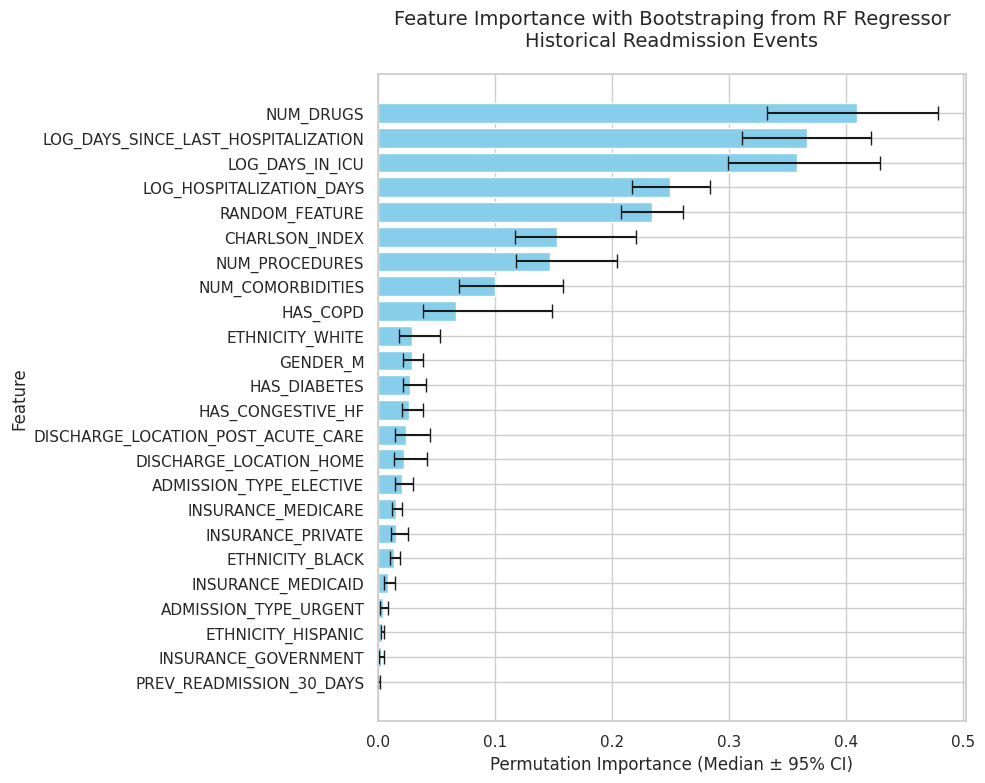

In [86]:
plot_feature_importance_with_bootstrapping(
    importance_df,
    title="Feature Importance with Bootstraping from RF Regressor\nHistorical Readmission Events",
    importance_type="permutation",
)

In [87]:
target_col = 'READMISSION_30_DAYS' # Regression target
importance_df_classification = get_rf_importance_scores(
    df=historical_events_copy_df,
    features=add_emission_candidates + ['RANDOM_FEATURE'],
    target_col=target_col,
    subject_id_col='SUBJECT_ID',
    task_type='classification',
    importance_type='gini',
    n_bootstraps=100,
    random_state=42,
    n_jobs=-1,
    verbose=True
)
print("Feature Importances from Random Forest Classifier:")
importance_df_classification

Bootstrapping: 100%|██████████| 100/100 [00:25<00:00,  3.89it/s]

Feature Importances from Random Forest Classifier:


feature  importance_mean  importance_median  \
1                       LOG_DAYS_IN_ICU         0.131462           0.130831   
23                       RANDOM_FEATURE         0.125313           0.125043   
0              LOG_HOSPITALIZATION_DAYS         0.124030           0.124139   
4                             NUM_DRUGS         0.113032           0.112865   
10  LOG_DAYS_SINCE_LAST_HOSPITALIZATION         0.095502           0.095711   
3                        NUM_PROCEDURES         0.075707           0.075341   
2                        CHARLSON_INDEX         0.072480           0.072471   
9                     NUM_COMORBIDITIES         0.050628           0.050667   
18                             GENDER_M         0.021240           0.021265   
7                              HAS_COPD         0.020346           0.020390   
6                          HAS_DIABETES         0.019339           0.019452   
8                     HAS_CONGESTIVE_HF         0.019368           0.019335   
17                      ETHNICITY_WHITE         0.016926           0.016983   
21                   INSURANCE_MEDICARE         0.014795           0.014782   
13              DISCHARGE_LOCATION_HOME         0.014155           0.014126   
14   DISCHARGE_LOCATION_POST_ACUTE_CARE         0.013703           0.013725   
22                    INSURANCE_PRIVATE         0.013167           0.013259   
15                      ETHNICITY_BLACK         0.012996           0.012969   
11              ADMISSION_TYPE_ELECTIVE         0.011966           0.011924   
20                   INSURANCE_MEDICAID         0.010153           0.010126   
5              PREV_READMISSION_30_DAYS         0.010028           0.009828   
16                   ETHNICITY_HISPANIC         0.006305           0.006284   
12                ADMISSION_TYPE_URGENT         0.004460           0.004468   
19                 INSURANCE_GOVERNMENT         0.002897           0.002830   

    importance_std  ci_lower  ci_upper  
1         0.003504  0.126568  0.138900  
23        0.003027  0.119398  0.132221  
0         0.002521  0.119675  0.129233  
4         0.003289  0.107898  0.119550  
10        0.003035  0.089352  0.100353  
3         0.001704  0.073166  0.079118  
2         0.002060  0.068615  0.076112  
9         0.001513  0.047853  0.053628  
18        0.000888  0.019655  0.022906  
7         0.000927  0.018486  0.022028  
6         0.000791  0.017693  0.020601  
8         0.000916  0.017722  0.020823  
17        0.000901  0.015413  0.018840  
21        0.000722  0.013331  0.016101  
13        0.000849  0.012775  0.016002  
14        0.000888  0.012046  0.015482  
22        0.000731  0.011776  0.014591  
15        0.000756  0.011503  0.014625  
11        0.000738  0.010831  0.013509  
20        0.000712  0.008909  0.011520  
5         0.000940  0.008533  0.011892  
16        0.000705  0.004796  0.007663  
12        0.000527  0.003555  0.005451  
19        0.000473  0.002102  0.003961

## Last Events with HMM Features

In [17]:
file_dir = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival/cox_ph_with_hmm_binary_time_covs_model/"
filename = "last_events_with_hidden_states.csv"
filepath = os.path.join(file_dir, filename)
print("Loadding last events with hidden states from:", filepath)
last_events_hmm_features_df = pd.read_csv(filepath)

Loadding last events with hidden states from: /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm_survival/cox_ph_with_hmm_binary_time_covs_model/last_events_with_hidden_states.csv


In [18]:
last_events_hmm_features_df["EVENT_DURATION"].describe()

count    1369.000000
mean       77.910881
std        46.308373
min         2.075000
25%        28.319444
50%       103.786111
75%       120.000000
max       120.000000
Name: EVENT_DURATION, dtype: float64

In [19]:
last_events_hmm_features_df.columns

Index(['index', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'ADMISSION_TYPE', 'ETHNICITY', 'INSURANCE', 'HOSPITALIZATION_DAYS',
       'NUM_COMORBIDITIES', 'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD',
       'HAS_CONGESTIVE_HF', 'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS',
       'PREV_DISCHTIME', 'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION',
       'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
       'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD', 'TOTAL_HOSPITALIZATIONS',
       'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'GENDER', 'DOB', 'DOD',
       'DOD_HOSP', 'AGE', 'CHARLSON_INDEX', 'FIRST_ADMITTIME',
       'LAST_DISCHTIME', 'PARTICIPATION_DAYS', 'TOTAL_PARTICIPATION_DAYS',

In [20]:
from recurrent_health_events_prediction.training.utils_hmm import sort_state_labels_by_severity

hidden_states_ordered = last_events_hmm_features_df["HEALTH_HIDDEN_RISK"].unique()
hidden_states_ordered = sort_state_labels_by_severity(hidden_states_ordered)
print("Unique hidden states ordered:", hidden_states_ordered)

Unique hidden states ordered: ['high', 'medium_2', 'medium_1', 'low']


In [21]:
last_readmissions_with_hmm_features_df = last_events_hmm_features_df[last_events_hmm_features_df['READMISSION_EVENT'] == 1]
last_hosp_no_readmissions_with_hmm_features_df = last_events_hmm_features_df[last_events_hmm_features_df['READMISSION_EVENT'] == 0]
hidden_states_count_patients_readmission_s = last_readmissions_with_hmm_features_df["HEALTH_HIDDEN_RISK"].value_counts()
hidden_states_count_patients_no_readmission_s = last_hosp_no_readmissions_with_hmm_features_df["HEALTH_HIDDEN_RISK"].value_counts()

compare_df = pd.DataFrame({
    'Readmission': hidden_states_count_patients_readmission_s,
    'No Readmission': hidden_states_count_patients_no_readmission_s
})
compare_df

Readmission  No Readmission
HEALTH_HIDDEN_RISK                             
medium_2                    430             341
medium_1                    147             222
high                        116              63
low                          28              22

### Event Duration Dist. per Hidden State

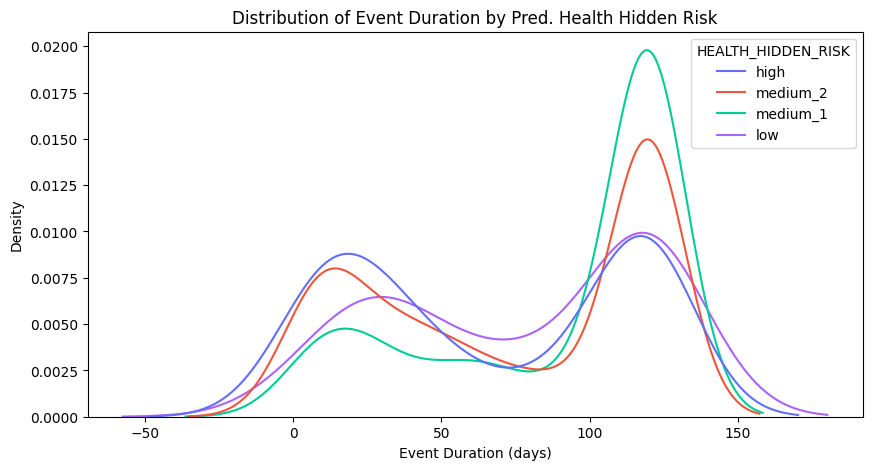

In [22]:
plt.figure(figsize=(10, 5))
sns.kdeplot(
    last_events_hmm_features_df,
    x='EVENT_DURATION',
    hue='HEALTH_HIDDEN_RISK',
    common_norm=False,
    hue_order=hidden_states_ordered,
)
plt.title('Distribution of Event Duration by Pred. Health Hidden Risk')
plt.xlabel('Event Duration (days)')
plt.ylabel('Density')
plt.show()

In [23]:
print("Categorical time: ", last_events_hmm_features_df['READMISSION_TIME_CAT'].unique())

Categorical time:  ['120+' '30-120' '0-30']


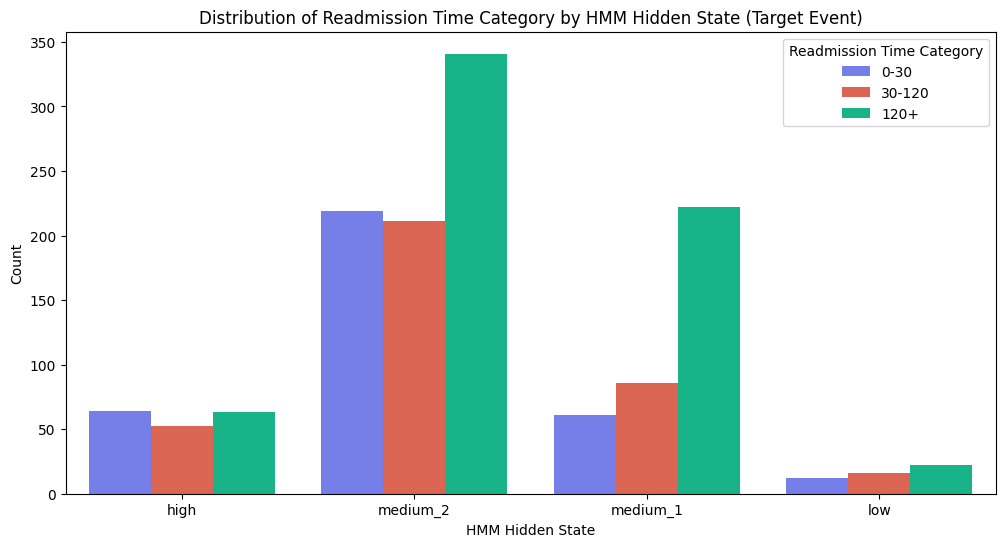

In [24]:
from recurrent_health_events_prediction.training.utils_hmm import plot_cat_event_time_by_hidden_state

fig = plot_cat_event_time_by_hidden_state(
    last_events_hmm_features_df,
    time_cat_col="READMISSION_TIME_CAT",
    title_suffix=" (Target Event)",
    event_name="readmission",
    hue_order=['0-30', '30-120', '120+'],
    hidden_states_order=hidden_states_ordered,
    show_plot=True,
)

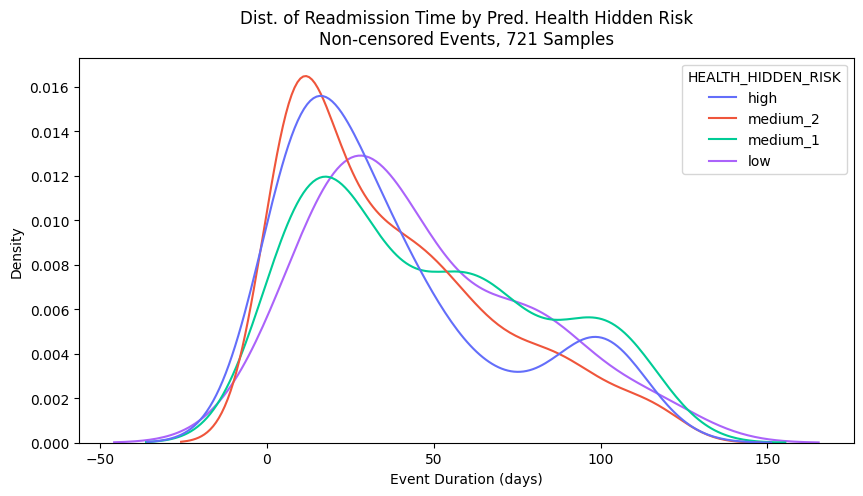

In [25]:
plt.figure(figsize=(10, 5))
sns.kdeplot(
    last_readmissions_with_hmm_features_df,
    x="EVENT_DURATION",
    hue="HEALTH_HIDDEN_RISK",
    common_norm=False,
    hue_order=hidden_states_ordered,
)
plt.title(
    f"Dist. of Readmission Time by Pred. Health Hidden Risk\nNon-censored Events, {len(last_readmissions_with_hmm_features_df)} Samples",
    pad=10
)
plt.xlabel("Event Duration (days)")
plt.ylabel("Density")
plt.show()

In [26]:
import plotly.express as px

px.box(last_readmissions_with_hmm_features_df,
        x='HEALTH_HIDDEN_RISK', y='EVENT_DURATION',
        color='HEALTH_HIDDEN_RISK',
        category_orders={'HEALTH_HIDDEN_RISK': hidden_states_ordered},
        title=f"Readmission Time by Pred. Hidden Risk State<br>Non-censored Events, {len(last_readmissions_with_hmm_features_df)} Samples",
        labels={'HEALTH_HIDDEN_RISK': 'Health Hidden Risk', 'EVENT_DURATION': 'Readmission Time (days)'},)

### Correlation of HMM Features with Readmission Time

In [27]:
from typing import List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

def plot_spearman_vs_target(
    df: pd.DataFrame,
    numerical_features: List[str],
    target: str,
    alpha: float = 0.05,
    order: str = "abs",   # "abs", "value", or "none"
    figsize: Tuple[int, int] = (10, 6),
):
    """
    Compute Spearman correlations between numerical_features and target, plot them,
    and return (figure, result_df).

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe containing the features and target.
    numerical_features : List[str]
        Columns in df to correlate against target.
    target : str
        Target column in df.
    alpha : float, optional
        Significance threshold for p-values. Default is 0.05.
    order : {"abs","value","none"}, optional
        Sort bars by absolute correlation ("abs"), raw value descending ("value"),
        or leave in given order ("none"). Default "abs".
    figsize : (int, int), optional
        Figure size for the bar plot. Default (10, 6).

    Returns
    -------
    fig : matplotlib.figure.Figure
        The generated matplotlib figure.
    result_df : pd.DataFrame
        Dataframe with columns: feature, spearman_corr, p_value, significant.
    """
    # Basic validation
    missing = [c for c in [target, *numerical_features] if c not in df.columns]
    if missing:
        raise ValueError(f"Columns not found in df: {missing}")

    correlations = []
    p_values = []

    for feat in numerical_features:
        coef, pval = spearmanr(df[feat], df[target], nan_policy='omit')
        correlations.append(coef)
        p_values.append(pval)

    result_df = pd.DataFrame({
        'feature': numerical_features,
        'spearman_corr': correlations,
        'p_value': p_values
    })

    # Mark significance
    result_df['significant'] = result_df['p_value'] < alpha

    # Ordering
    if order == "abs":
        result_df = result_df.reindex(
            result_df['spearman_corr'].abs().sort_values(ascending=False).index
        )
    elif order == "value":
        result_df = result_df.sort_values('spearman_corr', ascending=False)
    elif order == "none":
        pass
    else:
        raise ValueError("order must be one of {'abs','value','none'}")

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(
        data=result_df,
        x='feature',
        y='spearman_corr',
        hue='significant',
        palette={True: 'tab:blue', False: 'tab:gray'},
        ax=ax
    )
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_title(f"Spearman Correlation vs. {target}\n(Blue = Significant, Gray = Not Significant)")
    ax.set_ylabel("Spearman Correlation")
    ax.set_xlabel("Feature")
    ax.legend(title='Significant')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')
    fig.tight_layout()

    return fig, result_df


In [28]:
hmm_features = [col for col in last_readmissions_with_hmm_features_df.columns if 'PROB_HIDDEN_RISK' in col or 'PAST_COUNT' in col]
print("HMM numerical features to analyze:", hmm_features)

HMM numerical features to analyze: ['PROB_HIDDEN_RISK_LOW', 'PROB_HIDDEN_RISK_MEDIUM_1', 'PROB_HIDDEN_RISK_MEDIUM_2', 'PROB_HIDDEN_RISK_HIGH', 'PAST_COUNT_HIDDEN_RISK_HIGH', 'PAST_COUNT_HIDDEN_RISK_LOW', 'PAST_COUNT_HIDDEN_RISK_MEDIUM_1', 'PAST_COUNT_HIDDEN_RISK_MEDIUM_2']


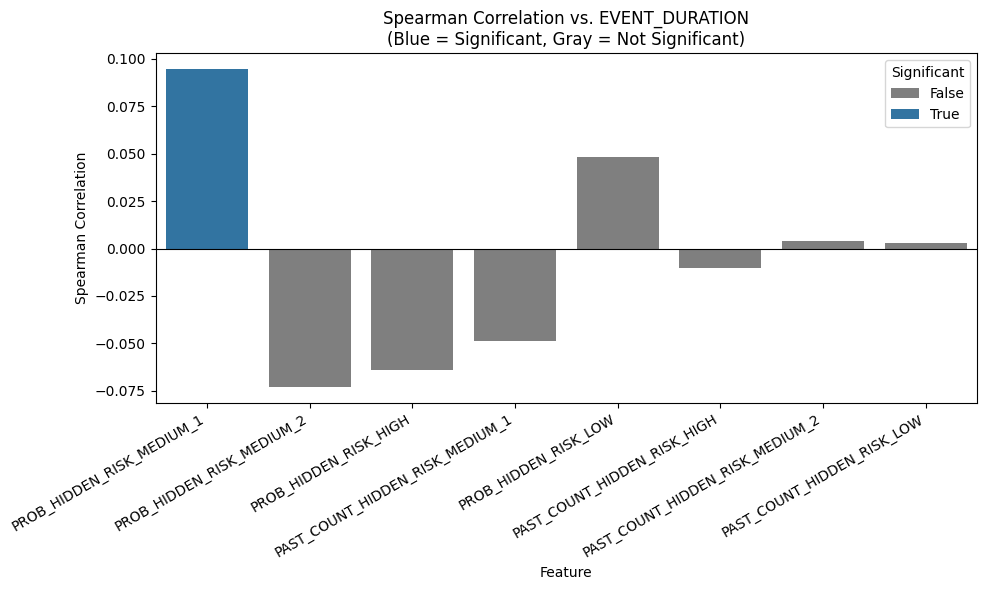

In [29]:
fig, corr_df = plot_spearman_vs_target(df=last_readmissions_with_hmm_features_df, numerical_features=hmm_features, target='EVENT_DURATION')

#### Kruskal-Wallis H-Test: Statistical Background

The **Kruskal-Wallis H-test** is a **non-parametric statistical test** used to determine whether there are statistically significant differences between the distributions of a continuous variable across three or more independent groups.

**What is the statistic being tested?**

* The test statistic, **H**, compares the mean ranks of the groups.
* It tests the **null hypothesis ($H_0$):** all groups come from the same distribution (i.e., their population medians are equal).

**Distributional Assumptions:**

* The Kruskal-Wallis test **does not assume normality**.
* It is appropriate for data that are **not normally distributed** and is often used as a non-parametric alternative to one-way ANOVA.
* The only assumptions are:

  * The observations are independent.
  * The variable is at least ordinal.
  * The distributions have the same shape (though the test is robust to differences in shape).

**Summary:**
The Kruskal-Wallis test is ideal when comparing more than two groups with continuous or ordinal data, especially when the normality assumption is questionable.

In [30]:
from scipy.stats import kruskal

# Create a dictionary to store groups for the Kruskal-Wallis test
groups = {state: last_readmissions_with_hmm_features_df[last_readmissions_with_hmm_features_df['HEALTH_HIDDEN_RISK'] == state]['EVENT_DURATION'] for state in hidden_states_ordered}
print("Performing Kruskal-Wallis test for Event Duration by Health Hidden Risk State...")
print("Groups for Kruskal-Wallis test:", groups.keys())
# Check if all groups have more than one sample
for state, group in groups.items():
    if len(group) < 2:
        print(f"Warning: Group '{state}' has only {len(group)} sample(s), which may affect the test results.")
print("Number of samples in each group:")
for state, group in groups.items():
    print(f"{state}: {len(group)} sample(s)")
# Perform the Kruskal-Wallis test
H, p = kruskal(*groups.values())
print(f"Kruskal-Wallis H={H}, p={p}")

Performing Kruskal-Wallis test for Event Duration by Health Hidden Risk State...
Groups for Kruskal-Wallis test: dict_keys(['high', 'medium_2', 'medium_1', 'low'])
Number of samples in each group:
high: 116 sample(s)
medium_2: 430 sample(s)
medium_1: 147 sample(s)
low: 28 sample(s)
Kruskal-Wallis H=10.853389499236838, p=0.01254565413483765


In [31]:
print(last_readmissions_with_hmm_features_df.groupby('HEALTH_HIDDEN_RISK')['EVENT_DURATION'].describe())

                    count       mean        std       min        25%  \
HEALTH_HIDDEN_RISK                                                     
high                116.0  37.823342  32.780485  2.136111  11.204167   
low                  28.0  45.920933  31.464675  2.665972  23.142535   
medium_1            147.0  47.374532  34.642339  2.076389  17.671875   
medium_2            430.0  37.820108  31.174219  2.075000  11.382292   

                          50%        75%         max  
HEALTH_HIDDEN_RISK                                    
high                25.092708  54.412500  113.131250  
low                 35.853819  71.649653  116.919444  
medium_1            41.004861  70.511111  117.090972  
medium_2            29.423958  57.264236  119.997222  


### Distributions of Hidden States

In [26]:
import plotly.express as px

px.histogram(last_events_hmm_features_df, x='HEALTH_HIDDEN_RISK', color='HEALTH_HIDDEN_RISK',
    title="Distribution of Pred. Health Hidden Risk States for Readmitted Patients within 120 days (Target Event)",
    labels={'HEALTH_HIDDEN_RISK': 'Health Hidden Risk'},
    category_orders={'HEALTH_HIDDEN_RISK': hidden_states_ordered},
    text_auto=True,
    color_discrete_sequence=px.colors.qualitative.Plotly
).update_layout(
    xaxis_title="Health Hidden Risk",
    yaxis_title="Count",
    legend_title_text="Health Hidden Risk"
).show()

In [17]:
import plotly.express as px

probs_last_readmissions_df = last_readmissions_with_hmm_features_df.copy()
prob_cols = [col for col in probs_last_readmissions_df.columns if col.startswith("PROB_HIDDEN_RISK_")]
probs_last_readmissions_df['HIDDEN_STATE_PROB'] = probs_last_readmissions_df[prob_cols].max(axis=1)

px.box(probs_last_readmissions_df, x='HEALTH_HIDDEN_RISK', y='HIDDEN_STATE_PROB', color='HEALTH_HIDDEN_RISK',
    title="Probability of Pred. Hidden Risk State for Readmitted Patients within 120 days (Target Event)",
    labels={'HEALTH_HIDDEN_RISK': 'Health Hidden Risk', 'HIDDEN_STATE_PROB': 'Probability of Hidden Risk State'},
    category_orders={'HEALTH_HIDDEN_RISK': hidden_states_ordered},
    color_discrete_sequence=px.colors.qualitative.Plotly
).update_layout(
    xaxis_title="Health Hidden Risk",
    yaxis_title="Probability of Hidden Risk State",
    legend_title_text="Health Hidden Risk"
).show()

probs_last_readmissions_df

index  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
3         3         256   188869  2170-06-15 03:06:00  2170-06-27 16:17:00   
6         6         323   128132  2119-09-21 20:34:00  2119-10-06 18:50:00   
8         8         357   101651  2199-10-20 12:05:00  2199-10-23 17:30:00   
12       12         518   185375  2111-07-06 14:36:00  2111-07-14 19:30:00   
15       15         665   152089  2119-02-25 20:13:00  2119-02-27 20:53:00   
...     ...         ...      ...                  ...                  ...   
1360   1360       98593   176136  2193-02-21 16:51:00  2193-03-05 19:30:00   
1362   1362       99346   177015  2142-05-13 13:17:00  2142-05-24 17:20:00   
1363   1363       99384   168087  2117-12-15 18:12:00  2117-12-23 15:25:00   
1364   1364       99439   152370  2179-09-29 16:19:00  2179-10-04 16:45:00   
1368   1368       99982   112748  2157-01-05 17:27:00  2157-01-12 13:00:00   

     ADMISSION_TYPE               ETHNICITY INSURANCE  HOSPITALIZATION_DAYS  \
3         EMERGENCY                   WHITE  Medicare             12.549306   
6         EMERGENCY                   WHITE  Medicare             14.927778   
8         EMERGENCY                   WHITE   Private              3.225694   
12        EMERGENCY           BLACK/AFRICAN  Medicare              8.204167   
15        EMERGENCY  BLACK/AFRICAN AMERICAN  Medicaid              2.027778   
...             ...                     ...       ...                   ...   
1360      EMERGENCY                   WHITE   Private             12.110417   
1362      EMERGENCY                   WHITE  Medicare             11.168750   
1363      EMERGENCY                   WHITE  Medicare              7.884028   
1364      EMERGENCY  BLACK/AFRICAN AMERICAN  Medicare              5.018056   
1368      EMERGENCY                   WHITE  Medicare              6.814583   

      NUM_COMORBIDITIES  ... DISCHARGE_LOCATION_HOME  \
3                     4  ...                       0   
6                     4  ...                       0   
8                     5  ...                       0   
12                    3  ...                       1   
15                    4  ...                       1   
...                 ...  ...                     ...   
1360                  5  ...                       0   
1362                  4  ...                       0   
1363                  6  ...                       0   
1364                  6  ...                       0   
1368                  3  ...                       1   

      DISCHARGE_LOCATION_POST_ACUTE_CARE  HEALTH_HIDDEN_RISK  \
3                                      1                high   
6                                      1                high   
8                                      1              medium   
12                                     0              medium   
15                                     0              medium   
...                                  ...                 ...   
1360                                   1                high   
1362                                   1              medium   
1363                                   1                high   
1364                                   1              medium   
1368                                   0              medium   

      PROB_HIDDEN_RISK_HIGH PROB_HIDDEN_RISK_MEDIUM  PROB_HIDDEN_RISK_LOW  \
3                  0.980522                0.019478                   0.0   
6                  0.998945                0.000000                   0.0   
8                  0.197983                0.802017                   0.0   
12                 0.000000                0.996193                   0.0   
15                 0.000000                1.000000                   0.0   
...                     ...                     ...                   ...   
1360               0.999804                0.000000                   0.0   
1362               0.480165                0.519835           

In [18]:
prob_cols = [col for col in probs_last_readmissions_df.columns if col.startswith("PROB_HIDDEN_RISK_")]
agg_dict = {col: ['mean', 'std'] for col in prob_cols}
agg_dict['HADM_ID'] = 'count'

probs_per_hidden_state_summary_df = probs_last_readmissions_df.groupby('HEALTH_HIDDEN_RISK').agg(agg_dict).reset_index().rename(columns={
    'HADM_ID': 'Count'})

# Flatten the multi-index columns for easier plotting
probs_per_hidden_state_summary_df.columns = ['_'.join(col).strip() for col in probs_per_hidden_state_summary_df.columns.values]

# Rename columns for clarity
mean_cols = [col for col in probs_per_hidden_state_summary_df.columns if '_mean' in col]
std_cols = [col for col in probs_per_hidden_state_summary_df.columns if '_std' in col]
rename_mean_dict = {col: col.replace('_mean', '').replace('PROB_HIDDEN_RISK_', '') for col in mean_cols}
rename_std_dict = {col: col.replace('_std', '_STD').replace('PROB_HIDDEN_RISK_', '') for col in std_cols}
rename_dict = {**rename_mean_dict, **rename_std_dict, 'HEALTH_HIDDEN_RISK_': 'HEALTH_HIDDEN_RISK', 'Count_count': 'Count'}
probs_per_hidden_state_summary_df = probs_per_hidden_state_summary_df.rename(columns=rename_dict)
probs_per_hidden_state_summary_df


HEALTH_HIDDEN_RISK      HIGH  HIGH_STD    MEDIUM  MEDIUM_STD  LOW  LOW_STD  \
0               high  0.895112  0.142732  0.104165    0.143248  0.0      0.0   
1                low  0.000000  0.000000  0.000000    0.000000  1.0      0.0   
2             medium  0.093792  0.136704  0.905258    0.136066  0.0      0.0   

   Count  
0    232  
1     28  
2    461

In [19]:

# Melt the dataframe for easier plotting
melted_df = probs_per_hidden_state_summary_df.melt(
    id_vars=['HEALTH_HIDDEN_RISK'],
    value_vars=[label for label in rename_mean_dict.values()],
    var_name='Probability_Type',
    value_name='Mean_Probability'
)

# Add standard deviation values
std_values = probs_per_hidden_state_summary_df.melt(
    id_vars=['HEALTH_HIDDEN_RISK'],
    value_vars=[label for label in rename_std_dict.values()],
    var_name='Probability_Type_Std',
    value_name='Std_Deviation'
)

# Merge mean and std data
melted_df['Std_Deviation'] = std_values['Std_Deviation']

# Plot using Plotly
fig = px.bar(
    melted_df,
    x='Probability_Type',
    y='Mean_Probability',
    error_y='Std_Deviation',
    color='Probability_Type',
    facet_col='HEALTH_HIDDEN_RISK',
    facet_col_wrap=2,
    title="Distribution of Probabilities with Standard Deviation",
    labels={'Probability_Type': 'Probability Hidden Risk', 'Mean_Probability': 'Mean Probability', 'HEALTH_HIDDEN_RISK': 'Health Hidden Risk'},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=600
)

fig.update_layout(
    xaxis_title="Probability Hidden Risk",
    yaxis_title="Mean Probability",
    legend_title_text="Probability Hidden Risk",
)

# Apply tick angle to all x-axes in the facets
for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].tickangle = -45

fig.show()

## Historical Events with HMM Features

In [4]:
model_name = "hmm_mimic_time_log_normal_min_emissions"
model_dir = f"/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/{model_name}"
filepath = os.path.join(model_dir, "training_seq_with_probs.csv")
historical_events_hmm_features_df = pd.read_csv(filepath)

In [5]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsHMM import RecurrentHealthEventsHMM
from recurrent_health_events_prediction.model.utils import load_model

model_path = os.path.join(model_dir, f"{model_name}.pkl")
print(f"Loading model from {model_path}")
hmm_feature_extractor_model: RecurrentHealthEventsHMM = load_model(model_path)

Loading model from /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/hmm_mimic_time_log_normal_min_emissions/hmm_mimic_time_log_normal_min_emissions.pkl


In [6]:
distributions_params_df = hmm_feature_extractor_model.get_features_dist_df(include_state_labels=True)
styled_df = distributions_params_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12px'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('font-size', '12px'), ('text-align', 'center')]}]
).set_properties(**{'border': '1px solid black', 'padding': '5px'})

styled_df

In [11]:
from recurrent_health_events_prediction.training.utils_hmm import sort_state_labels_by_severity

hidden_state_labels_order = sort_state_labels_by_severity(list(hmm_feature_extractor_model.get_hidden_state_labels().values()))

In [13]:
import plotly.express as px

px.box(historical_events_hmm_features_df,
        x='HEALTH_HIDDEN_RISK', y='DAYS_UNTIL_NEXT_HOSPITALIZATION',
        color='HEALTH_HIDDEN_RISK',
        category_orders={'HEALTH_HIDDEN_RISK': hidden_state_labels_order},
        title="True Days Until Next Hospit by Pred. Hidden Risk State - Training Data HMM",
        labels={'HEALTH_HIDDEN_RISK': 'Health Hidden Risk', 'DAYS_UNTIL_NEXT_HOSPITALIZATION': 'True Days Until Next Hospitalization'})

In [14]:
import plotly.express as px

probs_hist_readmissions_df = historical_events_hmm_features_df.copy()
probs_hist_readmissions_df['HIDDEN_STATE_PROB'] = probs_hist_readmissions_df[[col for col in probs_hist_readmissions_df.columns if col.startswith("PROB_HIDDEN_RISK_")]].max(axis=1)

px.box(probs_hist_readmissions_df, x='HEALTH_HIDDEN_RISK', y='HIDDEN_STATE_PROB', color='HEALTH_HIDDEN_RISK',
    title="Probability of Pred. Hidden Risk State - Training Data HMM",
    labels={'HEALTH_HIDDEN_RISK': 'Pred. Health Hidden Risk', 'HIDDEN_STATE_PROB': 'Pred. Probability of Hidden Risk State'},
    category_orders={'HEALTH_HIDDEN_RISK': ['high', 'medium', 'low', 'very_low']},
    color_discrete_sequence=px.colors.qualitative.Plotly
).update_layout(
    legend_title_text="Pred. Health Hidden Risk"
).show()

probs_hist_readmissions_df

SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0             36   182104  2131-04-30 07:15:00  2131-05-08 14:00:00   
1            107   191941  2115-02-20 17:41:00  2115-02-21 16:30:00   
2            124   172461  2160-06-24 21:25:00  2160-07-15 15:10:00   
3            124   112906  2161-12-17 03:39:00  2161-12-24 15:35:00   
4            138   108120  2131-10-31 08:00:00  2131-11-06 12:54:00   
...          ...      ...                  ...                  ...   
3371       99469   189343  2181-10-16 16:02:00  2181-10-23 15:35:00   
3372       99503   132396  2124-04-13 12:00:00  2124-04-13 17:14:00   
3373       99556   107452  2165-12-25 12:44:00  2166-01-08 16:53:00   
3374       99650   190854  2152-06-07 11:30:00  2152-06-13 15:00:00   
3375       99982   151454  2156-11-28 11:56:00  2156-12-08 13:45:00   

     ADMISSION_TYPE           ETHNICITY INSURANCE  HOSPITALIZATION_DAYS  \
0         EMERGENCY               WHITE  Medicare              8.281250   
1         EMERGENCY  HISPANIC OR LATINO   Private              0.950694   
2         EMERGENCY               WHITE   Private             20.739583   
3         EMERGENCY               WHITE  Medicare              7.497222   
4          ELECTIVE               WHITE   Private              6.204167   
...             ...                 ...       ...                   ...   
3371      EMERGENCY               WHITE  Medicare              6.981250   
3372       ELECTIVE               WHITE  Medicare              0.500000   
3373      EMERGENCY               WHITE  Medicare             14.172917   
3374       ELECTIVE               WHITE  Medicare              6.145833   
3375      EMERGENCY               WHITE  Medicare             10.075694   

      NUM_COMORBIDITIES                                TYPES_COMORBIDITIES  \
0                     2             ['other', 'chronic_pulmonary_disease']   
1                     2                         ['other', 'renal_disease']   
2                     3  ['other', 'chronic_pulmonary_disease', 'cerebr...   
3                     3  ['peripheral_vascular_disease', 'other', 'chro...   
4                     4  ['congestive_heart_failure', 'myocardial_infar...   
...                 ...                                                ...   
3371                  4  ['congestive_heart_failure', 'other', 'chronic...   
3372                  2                         ['other', 'renal_disease']   
3373                  5  ['myocardial_infarct', 'other', 'congestive_he...   
3374                  5  ['chronic_pulmonary_disease', 'other', 'periph...   
3375                  2              ['congestive_heart_failure', 'other']   

      ...  READMISSION_TIME_CAT  READMISSION_TIME_CAT_ENCODED  \
0     ...                  0-30                             0   
1     ...                  120+                             2   
2     ...                  120+                             2   
3     ...                  120+                             2   
4     ...                  120+                             2   
...   ...                   ...                           ...   
3371  ...                  120+                             2   
3372  ...                  120+                             2   
3373  ...                  120+                             2   
3374  ...                  120+                             2   
3375  ...                  0-30                             0   

      DISCHARGE_LOCATION_HOME DISCHARGE_LOCATION_POST_ACUTE_CARE  \
0                           1                                  0   
1                           1                                  0   
2                           1                                  0   
3                           1                                  0   
4                           1                                  0   
...                       ...                                ...   
3371                        1                             

In [16]:
historical_events_hmm_features_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE',
       'ETHNICITY', 'INSURANCE', 'HOSPITALIZATION_DAYS', 'NUM_COMORBIDITIES',
       'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD', 'HAS_CONGESTIVE_HF',
       'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS', 'PREV_DISCHTIME',
       'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION',
       'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
       'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD', 'TOTAL_HOSPITALIZATIONS',
       'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'GENDER', 'DOB', 'DOD',
       'DOD_HOSP', 'AGE', 'CHARLSON_INDEX', 'FIRST_ADMITTIME',
       'LAST_DISCHTIME', 'PARTICIPATION_DAYS', 'TOTAL_PARTICIPATION_DAYS',
       '

In [17]:
subject_id = 353
prob_cols = [col for col in historical_events_hmm_features_df.columns if col.startswith("PROB_HIDDEN_RISK_")]
time_col = ['ADMITTIME']
subject_df = historical_events_hmm_features_df.loc[historical_events_hmm_features_df['SUBJECT_ID'] == subject_id, time_col + prob_cols]

In [19]:
subject_df.columns

Index(['ADMITTIME', 'PROB_HIDDEN_RISK_LOW', 'PROB_HIDDEN_RISK_MEDIUM_2',
       'PROB_HIDDEN_RISK_MEDIUM_1', 'PROB_HIDDEN_RISK_HIGH'],
      dtype='object')

In [20]:
from typing import Optional, Dict, Sequence
import pandas as pd
import plotly.graph_objects as go

def plot_hidden_risk_over_time(
    df: pd.DataFrame,
    time_col: str = "ADMITTIME",
    prob_prefix: str = "PROB_HIDDEN_RISK",
    event_name: str = "Event",
    title: str = "Hidden State Probabilities",
    colors: Optional[Dict[str, str]] = None,  # keys are prob column names
    save_html_file_path: Optional[str] = None,
    show: bool = True,
) -> go.Figure:
    """
    Plot evolution of hidden risk probabilities over events for a single sequence.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must contain a time column and one or more probability columns starting with `prob_prefix`.
    time_col : str
        Name of the time column (e.g., 'ADMITTIME').
    prob_prefix : str
        Prefix used to auto-detect probability columns.
    event_name : str
        X-axis label (e.g., 'Hospitalization', 'Visit', etc.).
    title : str
        Plot title.
    colors : dict[str, str] | None
        Optional mapping from probability column name -> CSS color (e.g., '#1f77b4' or 'firebrick').
        Columns without a provided color will use Plotly's default cycle.
    save_html_file_path : str | None
        If provided, saves the figure as HTML ('.html' appended if missing).
    show : bool
        If True, calls fig.show().
        
    Returns
    -------
    go.Figure
    """

    if time_col not in df.columns:
        raise ValueError(f"'{time_col}' column not found in DataFrame.")

    # Auto-detect prob columns with the prefix
    prob_cols: Sequence[str] = [c for c in df.columns if c.startswith(prob_prefix)]
    if not prob_cols:
        raise ValueError(f"No probability columns found with prefix '{prob_prefix}'.")

    # Sort by time; tolerant to mixed/str datetimes
    _df = df.copy()
    _df[time_col] = pd.to_datetime(_df[time_col], errors="coerce")
    _df = _df.sort_values(time_col, kind="mergesort")  # stable sort to preserve ties

    # X axis: 1..N (event number)
    x_values = list(range(1, len(_df) + 1))

    # Build figure
    fig = go.Figure()

    # Ensure deterministic legend order by sorting columns
    for col in sorted(prob_cols):
        fig.add_trace(
            go.Scatter(
                x=x_values,
                y=_df[col].astype(float),
                mode="lines+markers",
                name=col,  # or customize label here if desired
                line=dict(color=(colors.get(col) if colors and col in colors else None)),
            )
        )

    # Layout
    fig.update_layout(
        title=title,
        xaxis_title=event_name,
        yaxis_title="Probability",
        legend_title="Latent Risk State",
        template="plotly_white",
        xaxis=dict(
            tickmode="linear",
            dtick=1,       # integer ticks
            tick0=1,       # start at 1
        ),
        yaxis=dict(range=[0, 1])  # assuming probabilities in [0,1]
    )

    # Optional save
    if save_html_file_path:
        if not save_html_file_path.endswith(".html"):
            save_html_file_path = save_html_file_path + ".html"
        fig.write_html(save_html_file_path)
        print(f"Plot saved as {save_html_file_path}")

    if show:
        fig.show()

    return fig


In [21]:
# colors is optional; provide only if you want specific colors per series
colors = {
    "PROB_HIDDEN_RISK_LOW": "#1f77b4",
    "PROB_HIDDEN_RISK_MEDIUM_2": "#ff7f0e",
    "PROB_HIDDEN_RISK_MEDIUM_1": "#2ca02c",
    "PROB_HIDDEN_RISK_HIGH": "#d62728",
}

fig = plot_hidden_risk_over_time(
    subject_df,
    time_col="ADMITTIME",
    event_name="Hospitalization",
    title="Hidden State Probabilities Over Time",
    colors=colors,
    save_html_file_path=None,  # or "hidden_risk_plot.html"
)
